# **Necessary** **Libraries**

In [ ]:
pip install numpy pandas matplotlib scikit-learn opencv-python keras tensorflow

In [ ]:
!pip install deap

In [ ]:
import numpy as np
import os
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import random
import pandas as pd
from tensorflow.keras.applications import VGG19, InceptionV3, DenseNet121
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Reshape, SimpleRNN, Flatten, Dense, Dropout
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from deap import base, creator, tools, algorithms

## **Loading Dataset**

In [ ]:
!fusermount -u /content/drive

!rm -rf /content/drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

zip_path = "/content/drive/MyDrive/archive.zip"
extract_dir = "/content/drive/MyDrive/Brain_Data_Organised"

!unzip -q -o "{zip_path}" -d "/content/drive/MyDrive"
print("Extracted to:", extract_dir)

!ls "/content/drive/MyDrive/Brain_Data_Organised"


Mounted at /content/drive
Extracted to: /content/drive/MyDrive/Brain_Data_Organised
Brain_Data_Organised  Normal  Stroke


In [ ]:
# import zipfile
# import os

# zip_path = "/content/drive/MyDrive/archive.zip"
# extract_dir = "/content/drive/MyDrive/Brain_Data_Organised"

# # Create extraction directory if not exists
# os.makedirs(extract_dir, exist_ok=True)

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

# print("Unzipped to:", extract_dir)
# #!ls "/content/drive/MyDrive/archive.zip"



In [ ]:
data_dir = "/content/drive/MyDrive/Brain_Data_Organised"
categories = ["Normal", "Stroke"]
labels = {"Normal": 0, "Stroke": 1}

# **Preprocessing**

In [ ]:
def show_sample_images():
    plt.figure(figsize=(12, 6))

    normal_path = os.path.join(data_dir, "Normal")
    stroke_path = os.path.join(data_dir, "Stroke")

    normal_img_name = random.choice(os.listdir(normal_path))
    stroke_img_name = random.choice(os.listdir(stroke_path))

    normal_img_path = os.path.join(normal_path, normal_img_name)
    stroke_img_path = os.path.join(stroke_path, stroke_img_name)

    normal_img_orig = cv2.imread(normal_img_path)
    normal_img_orig = cv2.cvtColor(normal_img_orig, cv2.COLOR_BGR2RGB)

    stroke_img_orig = cv2.imread(stroke_img_path)
    stroke_img_orig = cv2.cvtColor(stroke_img_orig, cv2.COLOR_BGR2RGB)

    plt.subplot(2, 2, 1)
    plt.imshow(normal_img_orig)
    plt.title(f"Original Normal Image\nShape: {normal_img_orig.shape}")
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(stroke_img_orig)
    plt.title(f"Original Stroke Image\nShape: {stroke_img_orig.shape}")
    plt.axis('off')

    IMG_SIZE = (224, 224)
    normal_img_resized = cv2.resize(normal_img_orig, IMG_SIZE)
    stroke_img_resized = cv2.resize(stroke_img_orig, IMG_SIZE)

    plt.subplot(2, 2, 3)
    plt.imshow(normal_img_resized)
    plt.title(f"Resized Normal Image\nShape: {normal_img_resized.shape}")
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(stroke_img_resized)
    plt.title(f"Resized Stroke Image\nShape: {stroke_img_resized.shape}")
    plt.axis('off')

    plt.tight_layout()
    plt.savefig('preprocessing_visualization.png')
    plt.show()

    return normal_img_orig, stroke_img_orig, normal_img_resized, stroke_img_resized

Visualizing preprocessing steps...


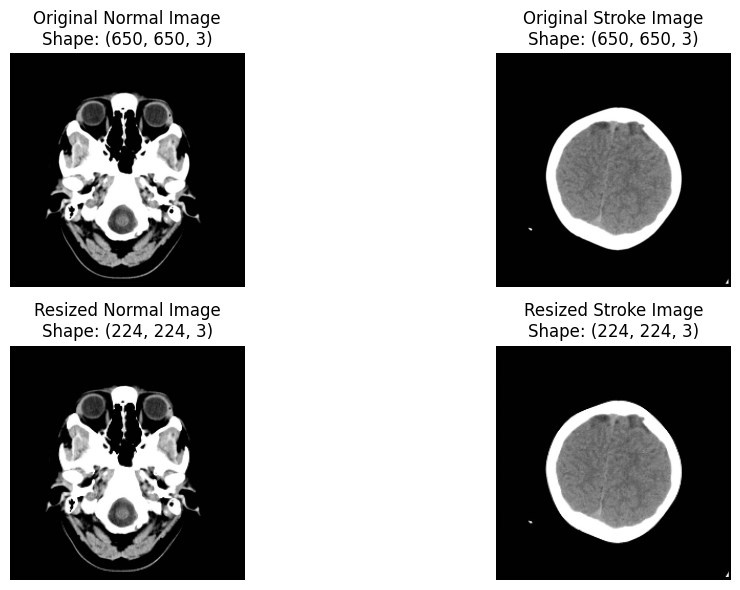

In [ ]:

print("Visualizing preprocessing steps...")
normal_img_orig, stroke_img_orig, normal_img_resized, stroke_img_resized = show_sample_images()

images, image_labels = [], []
IMG_SIZE = (224, 224)

for category in categories:
    path = os.path.join(data_dir, category)
    for img_name in os.listdir(path):
        img_path = os.path.join(path, img_name)
        try:
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, IMG_SIZE)
                images.append(img)
                image_labels.append(labels[category])
            else:
                print(f"Skipping unreadable image: {img_path}")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

images = np.array(images, dtype=np.float32) / 255.0
image_labels = np.array(image_labels)

# **Imbalance Handling**

In [ ]:
stroke_images = images[image_labels == 1]
normal_images = images[image_labels == 0]

print(f"Original dataset: {len(normal_images)} normal images, {len(stroke_images)} stroke images")

if len(stroke_images) < len(normal_images):
    stroke_images_resampled = resample(stroke_images, replace=True,
                                     n_samples=len(normal_images),
                                     random_state=42)
    images_balanced = np.vstack((stroke_images_resampled, normal_images))
    labels_balanced = np.array([1] * len(stroke_images_resampled) + [0] * len(normal_images))
else:
    normal_images_resampled = resample(normal_images, replace=True,
                                      n_samples=len(stroke_images),
                                      random_state=42)
    images_balanced = np.vstack((stroke_images, normal_images_resampled))
    labels_balanced = np.array([1] * len(stroke_images) + [0] * len(normal_images_resampled))

print(f"Balanced dataset: {len(images_balanced)} images with {np.sum(labels_balanced == 0)} normal and {np.sum(labels_balanced == 1)} stroke")

X_train, X_test, y_train, y_test = train_test_split(images_balanced, labels_balanced, test_size=0.2, random_state=42)

Original dataset: 1551 normal images, 950 stroke images
Balanced dataset: 3102 images with 1551 normal and 1551 stroke


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2481, 224, 224, 3)
(621, 224, 224, 3)
(2481,)
(621,)


# **AlexNet Feature Extractor**

In [ ]:
def create_alexnet(input_shape=(224, 224, 3)):
    model = Sequential([

        tf.keras.layers.Conv2D(96, 11, strides=4, padding='same', input_shape=input_shape, activation='relu'),
        tf.keras.layers.MaxPooling2D(3, strides=2),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(256, 5, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(3, strides=2),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(384, 3, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(384, 3, padding='same', activation='relu'),
        tf.keras.layers.Conv2D(256, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(3, strides=2),

        tf.keras.layers.GlobalAveragePooling2D()
    ])
    return model

# **ShuffleNet Feature Extractor**

In [ ]:

def create_shufflenet(input_shape=(224, 224, 3), groups=3):
    def shuffle_unit(x, filters, groups, strides=1):
        shortcut = x

        x = tf.keras.layers.Conv2D(filters, 1, padding='same', use_bias=False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        if groups > 1:
            channels_per_group = filters // groups
            x = tf.keras.layers.Lambda(
                lambda z: tf.reshape(
                    z, [-1, tf.shape(z)[1], tf.shape(z)[2], groups, channels_per_group]
                )
            )(x)

            x = tf.keras.layers.Lambda(
                lambda z: tf.transpose(z, [0, 1, 2, 4, 3])
            )(x)

            x = tf.keras.layers.Lambda(
                lambda z: tf.reshape(
                    z, [-1, tf.shape(z)[1], tf.shape(z)[2], filters]
                )
            )(x)

        x = tf.keras.layers.DepthwiseConv2D(3, strides=strides, padding='same', use_bias=False)(x)
        x = tf.keras.layers.BatchNormalization()(x)

        x = tf.keras.layers.Conv2D(filters, 1, padding='same', use_bias=False)(x)
        x = tf.keras.layers.BatchNormalization()(x)

        if strides == 1:
            x = tf.keras.layers.add([x, shortcut])

        return tf.keras.layers.Activation('relu')(x)

    inputs = tf.keras.layers.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(24, 3, strides=2, padding='same', use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPooling2D(3, strides=2, padding='same')(x)

    x = shuffle_unit(x, 240, groups, strides=2)
    x = shuffle_unit(x, 240, groups)
    x = shuffle_unit(x, 240, groups)
    x = shuffle_unit(x, 240, groups)

    x = shuffle_unit(x, 480, groups, strides=2)
    x = shuffle_unit(x, 480, groups)
    x = shuffle_unit(x, 480, groups)
    x = shuffle_unit(x, 480, groups)

    x = shuffle_unit(x, 960, groups, strides=2)
    x = shuffle_unit(x, 960, groups)
    x = shuffle_unit(x, 960, groups)
    x = shuffle_unit(x, 960, groups)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)

    model = Model(inputs=inputs, outputs=x)
    return model

## **Preprocessing Comparisons**



In [ ]:
def alexnet_preprocess(x):
    return (x - 127.5) / 127.5

def shufflenet_preprocess(x):
    return x / 255.0

def show_preprocessing_comparison():
    plt.figure(figsize=(15, 10))

    sample_img = X_train[0] * 255.0

    plt.subplot(2, 3, 1)
    plt.imshow(sample_img / 255.0)
    plt.title("Original Image")
    plt.axis("off")

    vgg_processed = vgg_preprocess(np.copy(sample_img))
    plt.subplot(2, 3, 2)
    plt.imshow((vgg_processed - vgg_processed.min()) / (vgg_processed.max() - vgg_processed.min()))
    plt.title("VGG19 Preprocessing")
    plt.axis("off")

    inception_processed = inception_preprocess(np.copy(sample_img))
    plt.subplot(2, 3, 3)
    plt.imshow((inception_processed - inception_processed.min()) / (inception_processed.max() - inception_processed.min()))
    plt.title("InceptionV3 Preprocessing")
    plt.axis("off")

    densenet_processed = densenet_preprocess(np.copy(sample_img))
    plt.subplot(2, 3, 4)
    plt.imshow((densenet_processed - densenet_processed.min()) / (densenet_processed.max() - densenet_processed.min()))
    plt.title("DenseNet121 Preprocessing")
    plt.axis("off")

    alexnet_processed = alexnet_preprocess(np.copy(sample_img / 255.0))
    plt.subplot(2, 3, 5)
    plt.imshow((alexnet_processed - alexnet_processed.min()) / (alexnet_processed.max() - alexnet_processed.min()))
    plt.title("AlexNet Preprocessing")
    plt.axis("off")

    shufflenet_processed = shufflenet_preprocess(np.copy(sample_img))
    plt.subplot(2, 3, 6)
    plt.imshow(shufflenet_processed)
    plt.title("ShuffleNet Preprocessing")
    plt.axis("off")

    plt.tight_layout()
    plt.savefig('model_preprocessing_comparison.png')
    plt.show()

### **Feature Extraction**

In [ ]:
from tensorflow.keras.utils import Sequence

class FeatureGen(Sequence):
    def __init__(self, X, preprocess_func, batch_size=32, target_size=(224, 224)):
        self.X = X
        self.preprocess_func = preprocess_func
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.X[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = np.array([cv2.resize(img, self.target_size) for img in batch_x])
        batch_x = self.preprocess_func(batch_x * 255.0)
        return batch_x

base_models = {
    "VGG19": (VGG19(weights='imagenet', include_top=False, pooling='avg'), vgg_preprocess, (224,224)),
    "InceptionV3": (InceptionV3(weights='imagenet', include_top=False, pooling='avg'), inception_preprocess, (299,299)),
    "DenseNet121": (DenseNet121(weights='imagenet', include_top=False, pooling='avg'), densenet_preprocess, (224,224)),
    "AlexNet": (create_alexnet(), alexnet_preprocess, (224,224)),
    "ShuffleNet": (create_shufflenet(), shufflenet_preprocess, (224,224))
}

extraction_times = {}
extracted_features_train = {}
extracted_features_test = {}

for model_name, (base_model, preprocess, input_size) in base_models.items():
    print(f"\n🔹 Extracting features with {model_name}...")

    train_gen = FeatureGen(X_train, preprocess, batch_size=32, target_size=input_size)
    test_gen = FeatureGen(X_test, preprocess, batch_size=32, target_size=input_size)

    start_time = time.time()
    features_train = base_model.predict(train_gen, verbose=1)
    features_test = base_model.predict(test_gen, verbose=1)
    end_time = time.time()

    extraction_times[model_name] = end_time - start_time
    extracted_features_train[model_name] = features_train
    extracted_features_test[model_name] = features_test

    print(f"{model_name} → Train shape: {features_train.shape}, Test shape: {features_test.shape}")
    print(f"Time taken: {extraction_times[model_name]:.2f} sec")

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



🔹 Extracting features with VGG19...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


78/78 ━━━━━━━━━━━━━━━━━━━━ 1722s 22s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 434s 22s/step
VGG19 → Train shape: (2481, 512), Test shape: (621, 512)
Time taken: 2196.06 sec

🔹 Extracting features with InceptionV3...
78/78 ━━━━━━━━━━━━━━━━━━━━ 594s 8s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 145s 7s/step
InceptionV3 → Train shape: (2481, 2048), Test shape: (621, 2048)
Time taken: 824.58 sec

🔹 Extracting features with DenseNet121...
78/78 ━━━━━━━━━━━━━━━━━━━━ 426s 5s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 104s 5s/step
DenseNet121 → Train shape: (2481, 1024), Test shape: (621, 1024)
Time taken: 530.62 sec

🔹 Extracting features with AlexNet...
78/78 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step
AlexNet → Train shape: (2481, 256), Test shape: (621, 256)
Time taken: 183.26 sec

🔹 Extracting features with ShuffleNet...
78/78 ━━━━━━━━━━━━━━━━━━━━ 173s 2s/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step
ShuffleNet → Train shape: (2481, 960), Test shape: (621, 960)
Time taken: 214.90 sec


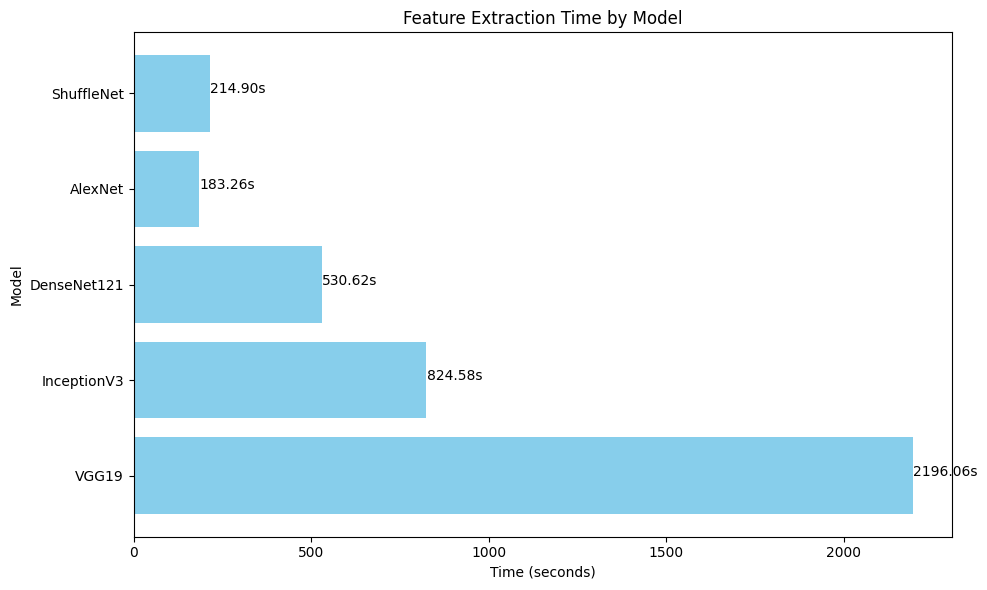

Combined feature shape: (2481, 4800)
Features saved to extracted_features.pkl


In [ ]:
import pickle

plt.figure(figsize=(10, 6))
plt.barh(list(extraction_times.keys()), list(extraction_times.values()), color='skyblue')
plt.xlabel('Time (seconds)')
plt.ylabel('Model')
plt.title('Feature Extraction Time by Model')
for i, v in enumerate(extraction_times.values()):
    plt.text(v + 0.5, i, f"{v:.2f}s")
plt.tight_layout()
plt.savefig('feature_extraction_times.png')
plt.show()

X_train_combined = np.concatenate(list(extracted_features_train.values()), axis=1)
X_test_combined = np.concatenate(list(extracted_features_test.values()), axis=1)
print(f"Combined feature shape: {X_train_combined.shape}")

with open("extracted_features.pkl", "wb") as f:
    pickle.dump({
        "X_train_combined": X_train_combined,
        "X_test_combined": X_test_combined,
        "y_train": y_train,
        "y_test": y_test,
        "extraction_times": extraction_times
    }, f)

print("Features saved to extracted_features.pkl")

In [ ]:
print(X_train_combined.shape)
print(X_test_combined.shape)

(2481, 4800)
(621, 4800)


Optimizing 4800 features with GA...
gen	nevals	avg     	max    	min    
0  	20    	0.850125	0.86649	0.83062
1  	12    	0.856551	0.86649	0.845128
2  	15    	0.860099	0.868506	0.847545
3  	13    	0.86411 	0.86972 	0.856407
4  	20    	0.866028	0.86972 	0.860051
5  	15    	0.864679	0.86972 	0.849965


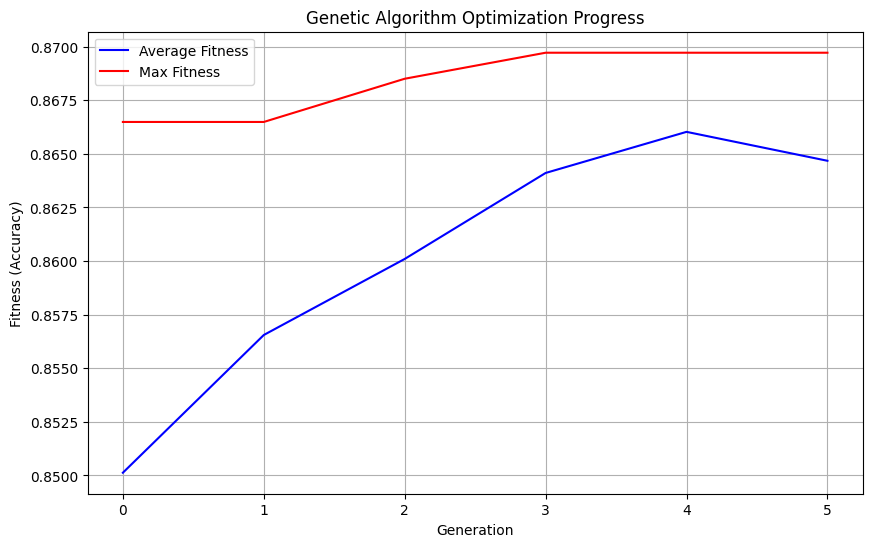


Final feature selection: 2367 features (49.3% of total)

Test set accuracy with selected features: 88.89%


In [ ]:
import numpy as np
from deap import base, creator, tools, algorithms
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt


if 'FitnessMax' in dir(creator):
    del creator.FitnessMax
    del creator.Individual

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

def enhanced_fitness(individual):
    selected = np.array(individual).astype(bool)
    num_selected = np.sum(selected)

    if num_selected < 10:
        return (0.0,)

    try:
        model = SVC(kernel='linear', C=1.0, random_state=42)
        scores = cross_val_score(model, X_train_combined[:, selected], y_train,
                                 cv=3, scoring='accuracy', n_jobs=-1)
        penalty = 0.001 * (num_selected / X_train_combined.shape[1])
        return (np.mean(scores) - penalty,)

    except ValueError:
        from sklearn.ensemble import RandomForestClassifier
        model = RandomForestClassifier(n_estimators=50, random_state=42)
        model.fit(X_train_combined, y_train)
        importances = model.feature_importances_
        top_features = np.argsort(importances)[-num_selected:]
        selected = np.zeros_like(individual, dtype=bool)
        selected[top_features] = True
        scores = cross_val_score(model, X_train_combined[:, selected], y_train,
                                 cv=3, scoring='accuracy', n_jobs=-1)
        return (np.mean(scores),)

toolbox = base.Toolbox()
toolbox.register("attr_bool", np.random.randint, 0, 2)
toolbox.register("individual", tools.initRepeat, creator.Individual,
                 toolbox.attr_bool, n=X_train_combined.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", enhanced_fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.03)
toolbox.register("select", tools.selTournament, tournsize=5)

population_size = 20
num_generations = 5

population = toolbox.population(n=population_size)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)
stats.register("min", np.min)

print(f"Optimizing {X_train_combined.shape[1]} features with GA...")
pop, logbook = algorithms.eaSimple(population, toolbox,
                                   cxpb=0.7,
                                   mutpb=0.3,
                                   ngen=num_generations,
                                   stats=stats,
                                   verbose=True)

plt.figure(figsize=(10, 6))
gen = logbook.select("gen")
avg = logbook.select("avg")
max_fit = logbook.select("max")

plt.plot(gen, avg, 'b-', label="Average Fitness")
plt.plot(gen, max_fit, 'r-', label="Max Fitness")
plt.title('Genetic Algorithm Optimization Progress')
plt.xlabel('Generation')
plt.ylabel('Fitness (Accuracy)')
plt.legend()
plt.grid(True)
plt.savefig('ga_optimization_progress.png', dpi=300, bbox_inches='tight')
plt.show()

best_individual = tools.selBest(pop, k=1)[0]
selected_features = np.array(best_individual).astype(bool)
num_selected = selected_features.sum()

if num_selected < 10:
    print("Warning: Suboptimal feature selection detected!")
    print("Falling back to correlation-based selection...")
    from sklearn.feature_selection import mutual_info_classif
    scores = mutual_info_classif(X_train_combined, y_train)
    selected_features = scores >= np.percentile(scores, 90)
    num_selected = selected_features.sum()

print(f"\nFinal feature selection: {num_selected} features "
      f"({num_selected/X_train_combined.shape[1]:.1%} of total)")

X_train_selected = X_train_combined[:, selected_features]
X_test_selected = X_test_combined[:, selected_features]

final_model = SVC(kernel='linear', C=1.0, random_state=42)
final_model.fit(X_train_selected, y_train)
test_accuracy = final_model.score(X_test_selected, y_test)
print(f"\nTest set accuracy with selected features: {test_accuracy:.2%}")


In [ ]:
def display_feature_counts(total_features, selected_count):
    print("\nFeature Selection Results:")
    print("="*40)
    print("{:<30} {:<10}".format("Total Features Available", total_features))
    print("{:<30} {:<10}".format("Features Selected", selected_count))
    print("{:<30} {:<10.2f}%".format("Selection Percentage",
                                    (selected_count/total_features)*100))
    print("="*40)

total_features = X_train_combined.shape[1]
num_selected = selected_features.sum()
display_feature_counts(total_features, num_selected)


if num_selected < 10:
    print("\nFallback Mechanism Activated!")
    print(f"Original selected features: {num_selected}")
    num_selected = selected_features.sum()
    display_feature_counts(total_features, num_selected)



Feature Selection Results:
Total Features Available       4800      
Features Selected              2367      
Selection Percentage           49.31     %


In [ ]:
print(X_test_selected.shape)
print(X_train_selected.shape)

(621, 2367)
(2481, 2367)


In [ ]:
def evaluate_model(y_true, y_pred, y_pred_proba=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    auc = 0
    if y_pred_proba is not None:
        try:
            auc = roc_auc_score(y_true, y_pred_proba)
        except:
            auc = 0

    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'auc': auc
    }

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Stroke'],
                yticklabels=['Normal', 'Stroke'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {title}')
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{title.lower().replace(" ", "_")}.png')
    plt.show()



Training SVM...
SVM Results:
Training time: 45.23 seconds
Accuracy: 0.8889
Precision: 0.8584
Recall: 0.9410
F1 Score: 0.8978
AUC: 0.9357
MSE: 0.0894
MAE: 0.1961
RMSE: 0.2990

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.83      0.88       299
           1       0.86      0.94      0.90       322

    accuracy                           0.89       621
   macro avg       0.89      0.89      0.89       621
weighted avg       0.89      0.89      0.89       621



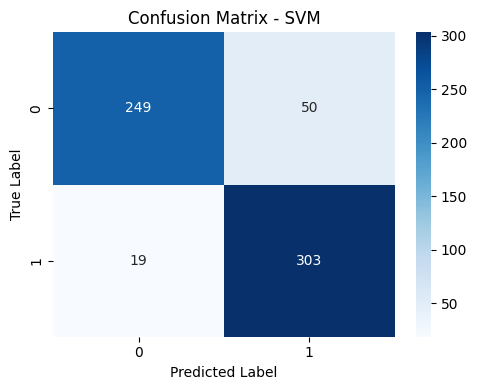

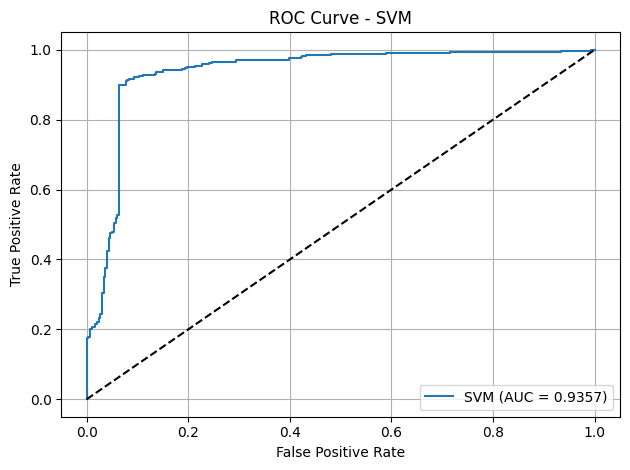


Training Random Forest...
Random Forest Results:
Training time: 14.42 seconds
Accuracy: 0.9452
Precision: 0.9832
Recall: 0.9099
F1 Score: 0.9452
AUC: 0.9862
MSE: 0.0852
MAE: 0.2459
RMSE: 0.2919

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.95       299
           1       0.98      0.91      0.95       322

    accuracy                           0.95       621
   macro avg       0.95      0.95      0.95       621
weighted avg       0.95      0.95      0.95       621



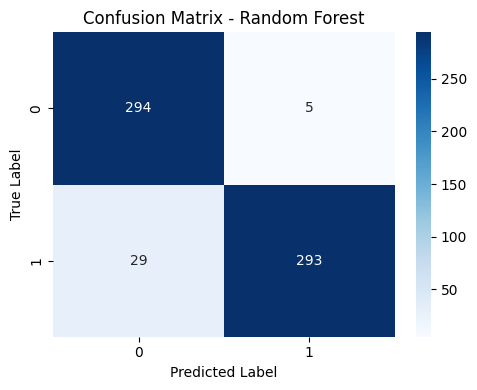

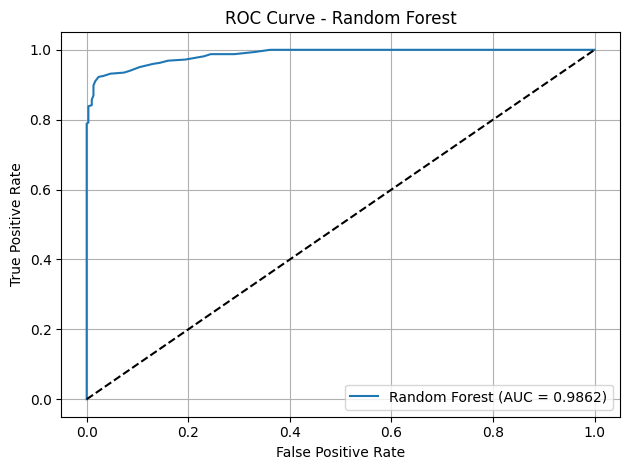


Training Decision Tree...
Decision Tree Results:
Training time: 13.72 seconds
Accuracy: 0.8454
Precision: 0.8038
Recall: 0.9286
F1 Score: 0.8617
AUC: 0.8422
MSE: 0.1546
MAE: 0.1546
RMSE: 0.3932

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.76      0.82       299
           1       0.80      0.93      0.86       322

    accuracy                           0.85       621
   macro avg       0.86      0.84      0.84       621
weighted avg       0.85      0.85      0.84       621



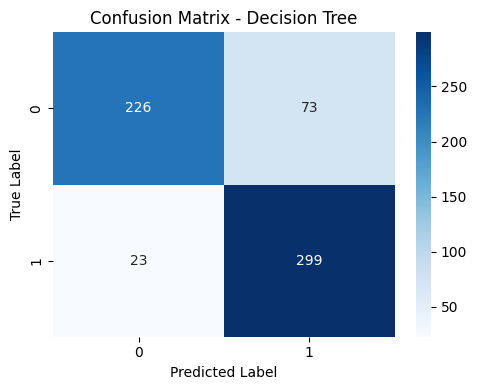

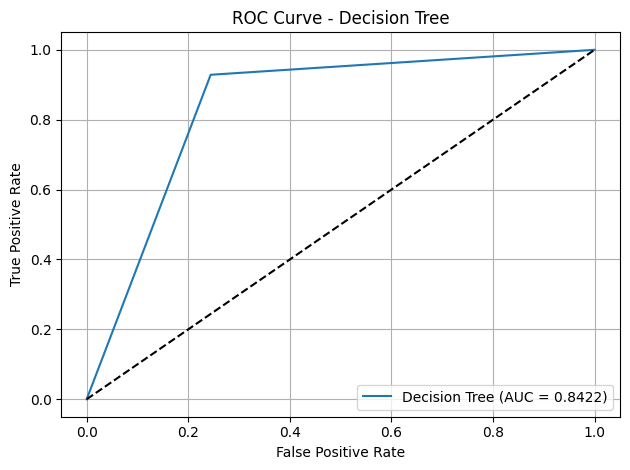


Training Logistic Regression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Results:
Training time: 32.96 seconds
Accuracy: 0.8953
Precision: 0.8620
Recall: 0.9503
F1 Score: 0.9040
AUC: 0.9379
MSE: 0.0879
MAE: 0.1374
RMSE: 0.2965

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.84      0.88       299
           1       0.86      0.95      0.90       322

    accuracy                           0.90       621
   macro avg       0.90      0.89      0.89       621
weighted avg       0.90      0.90      0.89       621



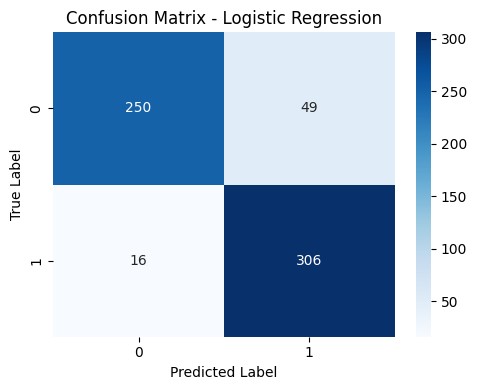

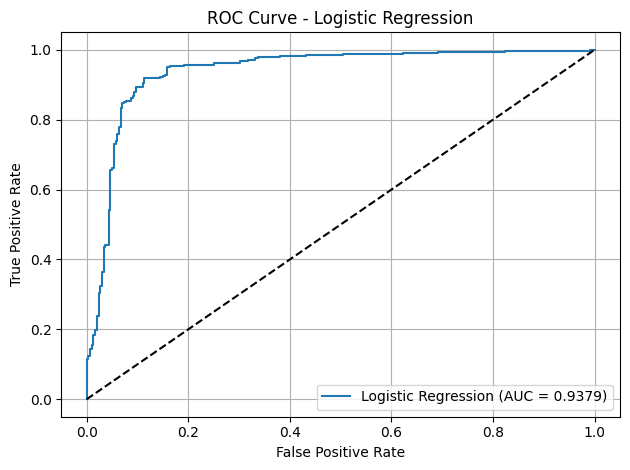


Training Naive Bayes...
Naive Bayes Results:
Training time: 0.18 seconds
Accuracy: 0.6763
Precision: 0.6971
Recall: 0.6646
F1 Score: 0.6804
AUC: 0.7514
MSE: 0.3137
MAE: 0.3227
RMSE: 0.5601

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.69      0.67       299
           1       0.70      0.66      0.68       322

    accuracy                           0.68       621
   macro avg       0.68      0.68      0.68       621
weighted avg       0.68      0.68      0.68       621



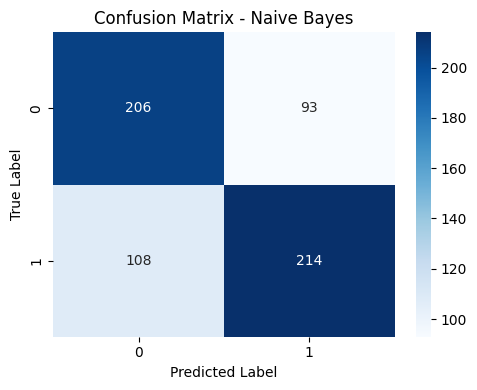

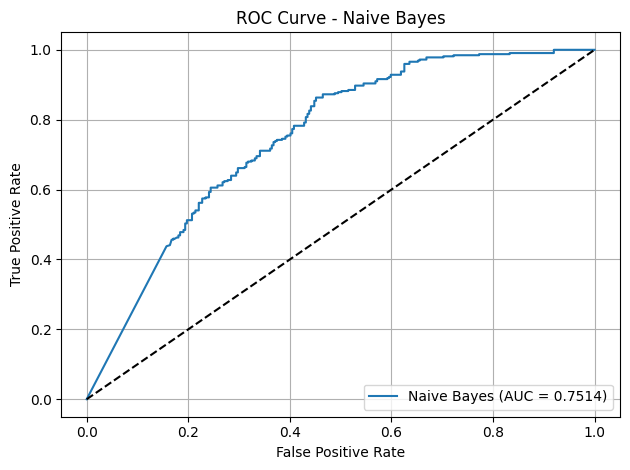


Model Comparison Table:
                 Model  Accuracy  Precision    Recall  F1 Score       AUC  \
0                  SVM  0.888889   0.858357  0.940994  0.897778  0.935697   
1        Random Forest  0.945250   0.983221  0.909938  0.945161  0.986248   
2        Decision Tree  0.845411   0.803763  0.928571  0.861671  0.842212   
3  Logistic Regression  0.895330   0.861972  0.950311  0.903988  0.937867   
4          Naive Bayes  0.676329   0.697068  0.664596  0.680445  0.751423   

   Training Time (s)  
0          45.231820  
1          14.420227  
2          13.724204  
3          32.958525  
4           0.181156  


In [ ]:
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score,
    recall_score, f1_score, roc_auc_score, confusion_matrix,
    mean_squared_error, mean_absolute_error, roc_curve
)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

models = {
    'SVM': SVC(kernel='linear', probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': GaussianNB()
}

results = {}
model_metrics = []

def evaluate_model(y_true, y_pred, y_pred_proba=None):
    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1_score': f1_score(y_true, y_pred),
        'auc': roc_auc_score(y_true, y_pred_proba) if y_pred_proba is not None else 0
    }

    if y_pred_proba is not None:
        metrics['mse'] = mean_squared_error(y_true, y_pred_proba)
        metrics['mae'] = mean_absolute_error(y_true, y_pred_proba)
        metrics['rmse'] = np.sqrt(mean_squared_error(y_true, y_pred_proba))  # fixed
    return metrics


def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

for name, model in models.items():
    start_time = time.time()
    print(f"\nTraining {name}...")
    model.fit(X_train_selected, y_train)

    y_pred = model.predict(X_test_selected)
    y_pred_proba = model.predict_proba(X_test_selected)[:, 1] if hasattr(model, "predict_proba") else None

    metrics = evaluate_model(y_test, y_pred, y_pred_proba)
    training_time = time.time() - start_time

    results[name] = {
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'metrics': metrics,
        'training_time': training_time
    }

    print(f"{name} Results:")
    print(f"Training time: {training_time:.2f} seconds")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"F1 Score: {metrics['f1_score']:.4f}")
    if metrics['auc'] > 0:
        print(f"AUC: {metrics['auc']:.4f}")
    if 'mse' in metrics:
        print(f"MSE: {metrics['mse']:.4f}")
        print(f"MAE: {metrics['mae']:.4f}")
        print(f"RMSE: {metrics['rmse']:.4f}")

    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    plot_confusion_matrix(y_test, y_pred, name)

    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f'{name} (AUC = {metrics["auc"]:.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    model_metrics.append({
        'Model': name,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1 Score': metrics['f1_score'],
        'AUC': metrics['auc'] if metrics['auc'] > 0 else None,
        'Training Time (s)': training_time
    })

df_metrics = pd.DataFrame(model_metrics)
print("\nModel Comparison Table:")
print(df_metrics)


In [ ]:

print(f"Original X_train_selected shape: {X_train_selected.shape}")
print(f"Original X_test_selected shape: {X_test_selected.shape}")

n_features = X_train_selected.shape[1]
timesteps = 1
feature_dim = 1

if n_features > 100:
    timesteps = 10
    feature_dim = n_features // timesteps
    remainder = n_features % timesteps

    if remainder > 0:
        padding = np.zeros((X_train_selected.shape[0], timesteps - remainder))
        X_train_selected_padded = np.hstack([X_train_selected, padding])
        padding = np.zeros((X_test_selected.shape[0], timesteps - remainder))
        X_test_selected_padded = np.hstack([X_test_selected, padding])
        n_features = X_train_selected_padded.shape[1]
        feature_dim = n_features // timesteps

        X_train_lstm = X_train_selected_padded.reshape(X_train_selected_padded.shape[0], timesteps, feature_dim)
        X_test_lstm = X_test_selected_padded.reshape(X_test_selected_padded.shape[0], timesteps, feature_dim)
    else:
        X_train_lstm = X_train_selected.reshape(X_train_selected.shape[0], timesteps, feature_dim)
        X_test_lstm = X_test_selected.reshape(X_test_selected.shape[0], timesteps, feature_dim)
else:
    X_train_lstm = X_train_selected.reshape(X_train_selected.shape[0], n_features, 1)
    X_test_lstm = X_test_selected.reshape(X_test_selected.shape[0], n_features, 1)
    timesteps = n_features
    feature_dim = 1

print(f"Reshaped X_train_lstm shape: {X_train_lstm.shape}")
print(f"Reshaped X_test_lstm shape: {X_test_lstm.shape}")


Original X_train_selected shape: (2481, 2367)
Original X_test_selected shape: (621, 2367)
Reshaped X_train_lstm shape: (2481, 10, 237)
Reshaped X_test_lstm shape: (621, 10, 237)



Fold 1

Epoch 58: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 68: ReduceLROnPlateau reducing learning rate to 1e-05.
Final Training Loss: 0.5821
Final Validation Loss: 1.0711
Final Training Accuracy: 0.9995
Final Validation Accuracy: 0.9195
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Confusion Matrix:


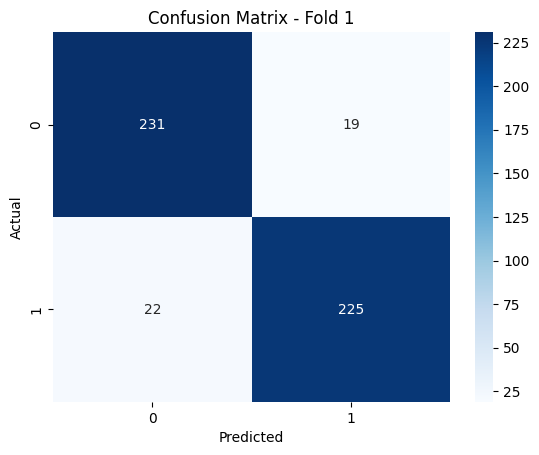

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92       250
           1       0.92      0.91      0.92       247

    accuracy                           0.92       497
   macro avg       0.92      0.92      0.92       497
weighted avg       0.92      0.92      0.92       497


Fold 2
Final Training Loss: 0.4072
Final Validation Loss: 0.4059
Final Training Accuracy: 0.9995
Final Validation Accuracy: 1.0000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Confusion Matrix:


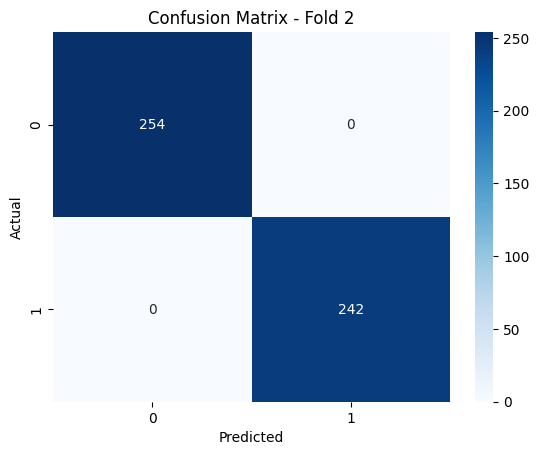

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       254
           1       1.00      1.00      1.00       242

    accuracy                           1.00       496
   macro avg       1.00      1.00      1.00       496
weighted avg       1.00      1.00      1.00       496


Fold 3
Final Training Loss: 0.2807
Final Validation Loss: 0.2797
Final Training Accuracy: 0.9995
Final Validation Accuracy: 1.0000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Confusion Matrix:


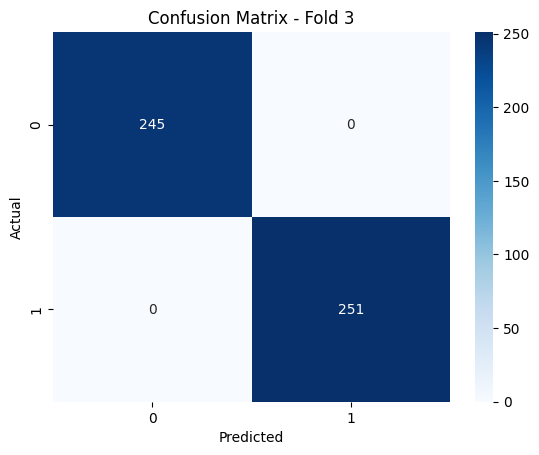

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       245
           1       1.00      1.00      1.00       251

    accuracy                           1.00       496
   macro avg       1.00      1.00      1.00       496
weighted avg       1.00      1.00      1.00       496


Fold 4
Final Training Loss: 0.2320
Final Validation Loss: 0.2257
Final Training Accuracy: 0.9960
Final Validation Accuracy: 0.9980
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Confusion Matrix:


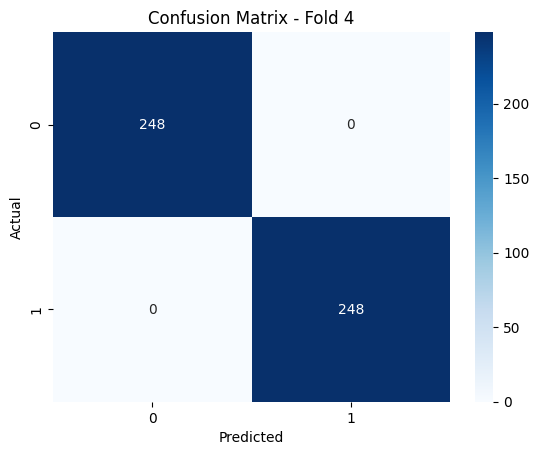

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       248
           1       1.00      1.00      1.00       248

    accuracy                           1.00       496
   macro avg       1.00      1.00      1.00       496
weighted avg       1.00      1.00      1.00       496


Fold 5
Final Training Loss: 0.1907
Final Validation Loss: 0.1894
Final Training Accuracy: 0.9995
Final Validation Accuracy: 1.0000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Confusion Matrix:


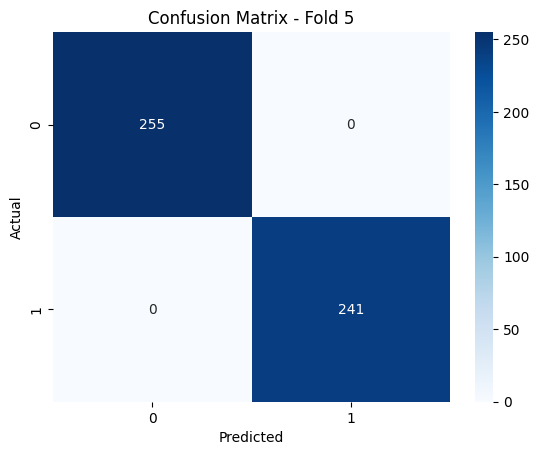

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       255
           1       1.00      1.00      1.00       241

    accuracy                           1.00       496
   macro avg       1.00      1.00      1.00       496
weighted avg       1.00      1.00      1.00       496


Optimized RNN Average Metrics:
Accuracy: 0.9835
Precision: 0.9844
Recall: 0.9822
F1 Score: 0.9833
AUC: 0.9936
Training Time (s): 1233.5000


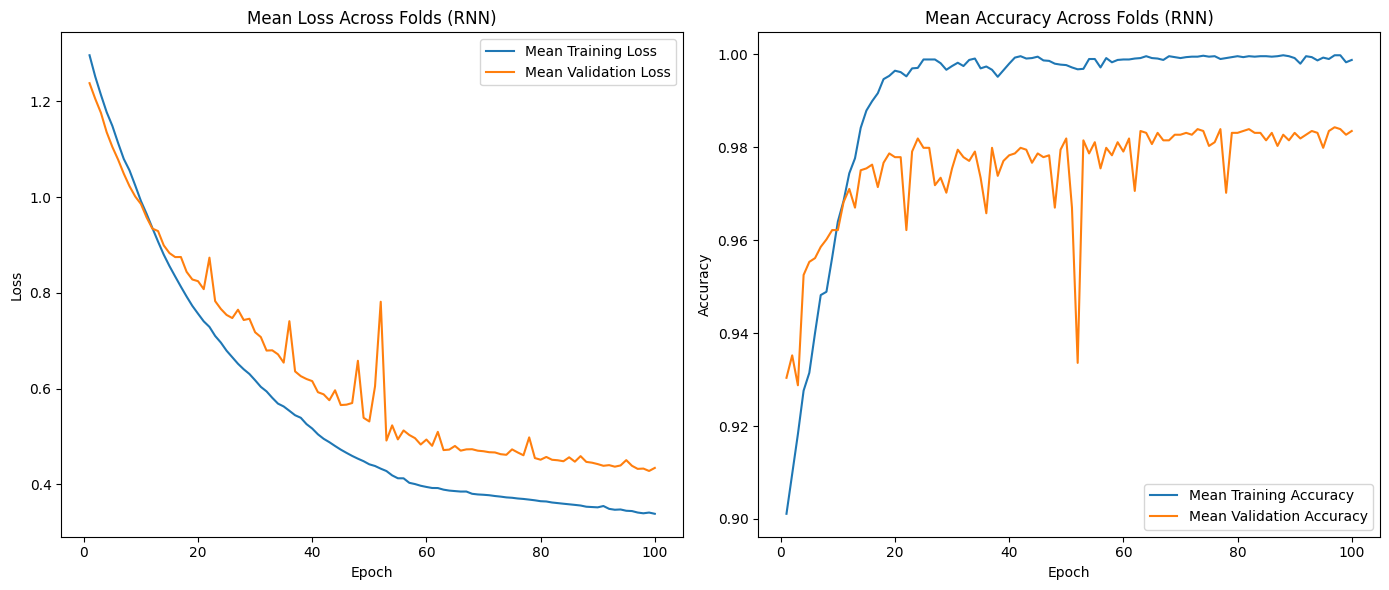

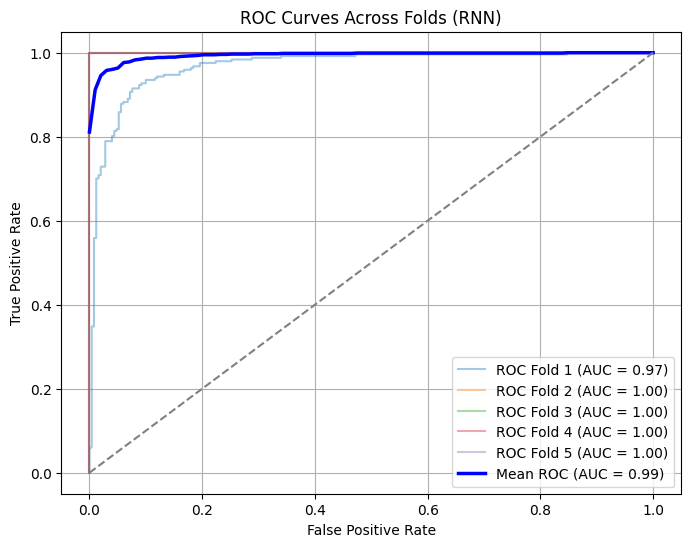


Updated Model Metrics Table:
                 Model  Accuracy  Precision    Recall  F1 Score       AUC  \
0                  SVM  0.888889   0.858357  0.940994  0.897778  0.935697   
1        Random Forest  0.945250   0.983221  0.909938  0.945161  0.986248   
2        Decision Tree  0.845411   0.803763  0.928571  0.861671  0.842212   
3  Logistic Regression  0.895330   0.861972  0.950311  0.903988  0.937867   
4          Naive Bayes  0.676329   0.697068  0.664596  0.680445  0.751423   
5                  RNN  0.983501   0.984426  0.982186  0.983299  0.993592   

   Training Time (s)  
0          45.231820  
1          14.420227  
2          13.724204  
3          32.958525  
4           0.181156  
5        1233.500000  


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.model_selection import KFold
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, SimpleRNN, BatchNormalization
import seaborn as sns
import time

model_metrics = [m for m in model_metrics if m['Model'] != 'RNN']

start_time = time.time()

rnn_model = Sequential([
    Input(shape=(timesteps, feature_dim)),

    SimpleRNN(256, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.3),
    BatchNormalization(),

    SimpleRNN(128, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.3),
    BatchNormalization(),

    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
rnn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5, verbose=1)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rnn_metrics = []
all_fpr, all_tpr, all_auc = [], [], []
train_loss_all, val_loss_all = [], []
train_acc_all, val_acc_all = [], []
fold = 1

for train_idx, val_idx in kf.split(X_train_lstm):
    print(f"\nFold {fold}")

    X_tr, X_val = X_train_lstm[train_idx], X_train_lstm[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    history = rnn_model.fit(
        X_tr, y_tr,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    train_loss_all.append(history.history['loss'])
    val_loss_all.append(history.history['val_loss'])
    train_acc_all.append(history.history['accuracy'])
    val_acc_all.append(history.history['val_accuracy'])

    print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
    print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
    print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

    y_pred_val_proba = rnn_model.predict(X_val).flatten()
    fpr, tpr, _ = roc_curve(y_val, y_pred_val_proba)
    roc_auc = auc(fpr, tpr)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)

    y_pred_val = (y_pred_val_proba > 0.5).astype(int).flatten()

    metrics = evaluate_model(y_val, y_pred_val, y_pred_val_proba)
    cv_rnn_metrics.append({
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1 Score': metrics['f1_score'],
        'AUC': metrics['auc']
    })

    print("Confusion Matrix:")
    cm = confusion_matrix(y_val, y_pred_val)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("Classification Report:")
    print(classification_report(y_val, y_pred_val))

    fold += 1

training_time = time.time() - start_time

mean_rnn_metrics = {
    'Model': 'RNN',
    'Accuracy': np.mean([m['Accuracy'] for m in cv_rnn_metrics]),
    'Precision': np.mean([m['Precision'] for m in cv_rnn_metrics]),
    'Recall': np.mean([m['Recall'] for m in cv_rnn_metrics]),
    'F1 Score': np.mean([m['F1 Score'] for m in cv_rnn_metrics]),
    'AUC': np.mean([m['AUC'] for m in cv_rnn_metrics]),
    'Training Time (s)': round(training_time, 2)
}

print("\nOptimized RNN Average Metrics:")
for k, v in mean_rnn_metrics.items():
    if k != "Model" and v is not None:
        print(f"{k}: {v:.4f}")

min_epochs = min(map(len, train_loss_all))
train_loss_all = np.array([x[:min_epochs] for x in train_loss_all])
val_loss_all = np.array([x[:min_epochs] for x in val_loss_all])
train_acc_all = np.array([x[:min_epochs] for x in train_acc_all])
val_acc_all = np.array([x[:min_epochs] for x in val_acc_all])

epochs = range(1, min_epochs + 1)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, np.mean(train_loss_all, axis=0), label='Mean Training Loss')
plt.plot(epochs, np.mean(val_loss_all, axis=0), label='Mean Validation Loss')
plt.title('Mean Loss Across Folds (RNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, np.mean(train_acc_all, axis=0), label='Mean Training Accuracy')
plt.plot(epochs, np.mean(val_acc_all, axis=0), label='Mean Validation Accuracy')
plt.title('Mean Accuracy Across Folds (RNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], label=f'ROC Fold {i+1} (AUC = {all_auc[i]:.2f})', alpha=0.4)

mean_fpr = np.linspace(0, 1, 100)
interp_tprs = [np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(all_fpr, all_tpr)]
mean_tpr = np.mean(interp_tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='blue', lw=2.5, label=f'Mean ROC (AUC = {mean_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Across Folds (RNN)')
plt.legend()
plt.grid(True)
plt.show()

model_metrics.append(mean_rnn_metrics)
df_metrics = pd.DataFrame(model_metrics)
print("\nUpdated Model Metrics Table:")
print(df_metrics)



Fold 1

Epoch 48: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.

Epoch 53: ReduceLROnPlateau reducing learning rate to 1e-05.
Final Training Loss: 0.6158
Final Validation Loss: 1.0564
Final Training Accuracy: 0.9955
Final Validation Accuracy: 0.8672
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Confusion Matrix:


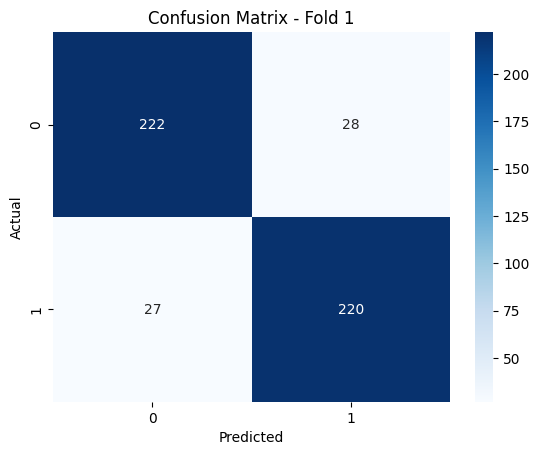

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89       250
           1       0.89      0.89      0.89       247

    accuracy                           0.89       497
   macro avg       0.89      0.89      0.89       497
weighted avg       0.89      0.89      0.89       497


Fold 2
Final Training Loss: 0.5537
Final Validation Loss: 0.5902
Final Training Accuracy: 0.9970
Final Validation Accuracy: 0.9879
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Confusion Matrix:


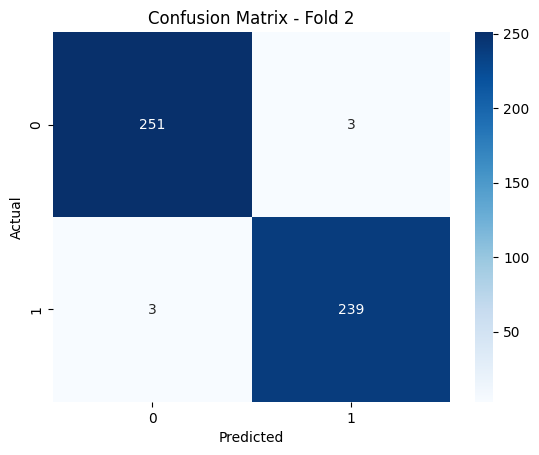

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       254
           1       0.99      0.99      0.99       242

    accuracy                           0.99       496
   macro avg       0.99      0.99      0.99       496
weighted avg       0.99      0.99      0.99       496


Fold 3
Final Training Loss: 0.4379
Final Validation Loss: 0.4392
Final Training Accuracy: 0.9995
Final Validation Accuracy: 0.9980
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Confusion Matrix:


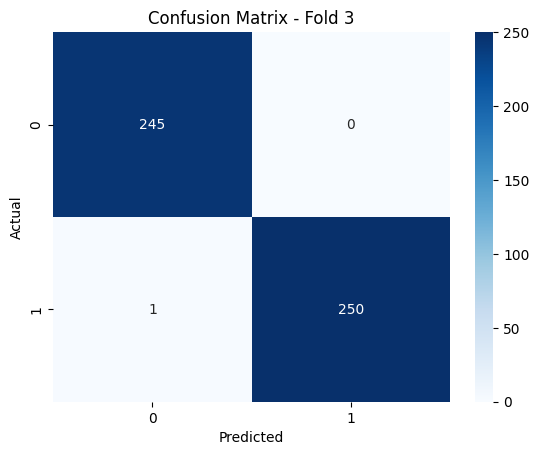

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       245
           1       1.00      1.00      1.00       251

    accuracy                           1.00       496
   macro avg       1.00      1.00      1.00       496
weighted avg       1.00      1.00      1.00       496


Fold 4
Final Training Loss: 0.3543
Final Validation Loss: 0.3500
Final Training Accuracy: 0.9975
Final Validation Accuracy: 0.9960
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Confusion Matrix:


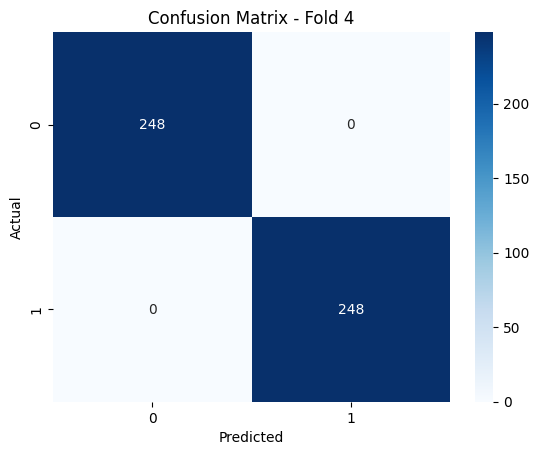

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       248
           1       1.00      1.00      1.00       248

    accuracy                           1.00       496
   macro avg       1.00      1.00      1.00       496
weighted avg       1.00      1.00      1.00       496


Fold 5
Final Training Loss: 0.2944
Final Validation Loss: 0.2858
Final Training Accuracy: 0.9995
Final Validation Accuracy: 1.0000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Confusion Matrix:


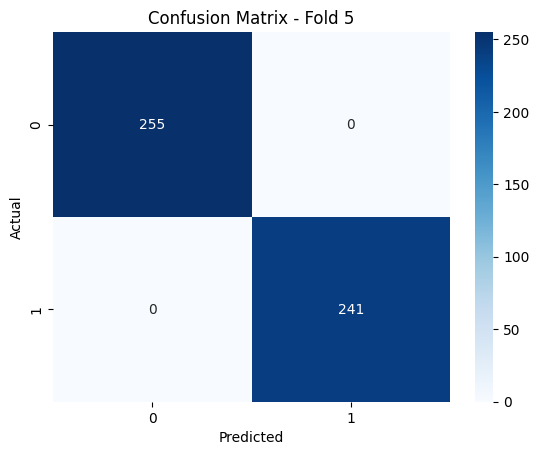

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       255
           1       1.00      1.00      1.00       241

    accuracy                           1.00       496
   macro avg       1.00      1.00      1.00       496
weighted avg       1.00      1.00      1.00       496


RNN Average Metrics:
Accuracy: 0.9750
Precision: 0.9749
Recall: 0.9749
F1 Score: 0.9749
AUC: 0.9885

Mean Final Training & Validation Metrics:
Mean Final Training Loss: 0.4512
Mean Final Validation Loss: 0.5443
Mean Final Training Accuracy: 0.9978
Mean Final Validation Accuracy: 0.9698


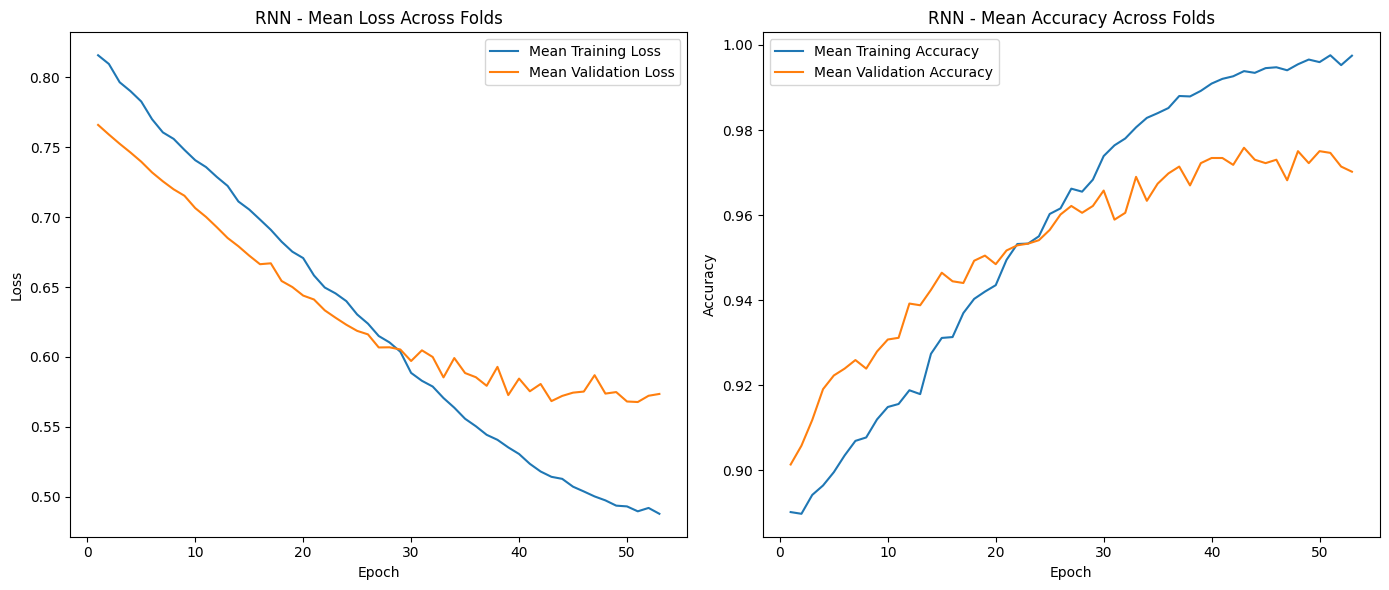

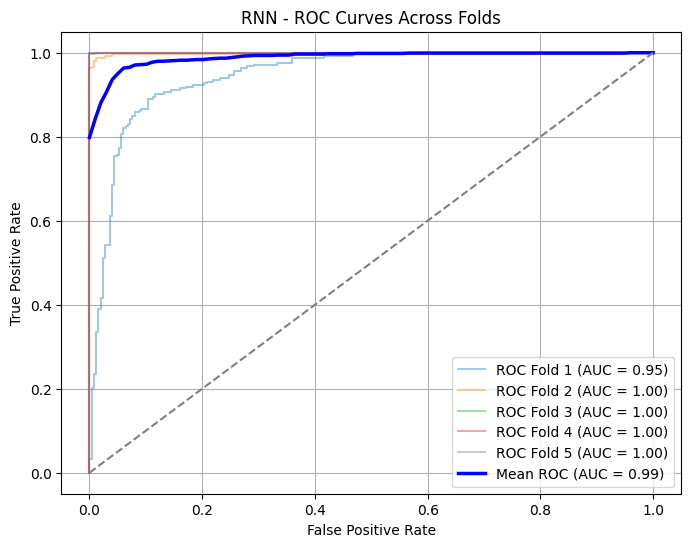


Final Classification Report on Entire Training Data (RNN):
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1252
           1       1.00      1.00      1.00      1229

    accuracy                           1.00      2481
   macro avg       1.00      1.00      1.00      2481
weighted avg       1.00      1.00      1.00      2481



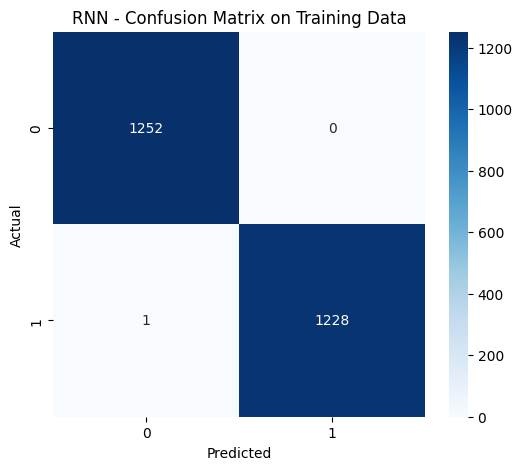


Updated Model Metrics Table:
                 Model  Accuracy  Precision    Recall  F1 Score       AUC  \
0                  SVM  0.888889   0.858357  0.940994  0.897778  0.935697   
1        Random Forest  0.945250   0.983221  0.909938  0.945161  0.986248   
2        Decision Tree  0.845411   0.803763  0.928571  0.861671  0.842212   
3  Logistic Regression  0.895330   0.861972  0.950311  0.903988  0.937867   
4          Naive Bayes  0.676329   0.697068  0.664596  0.680445  0.751423   
5                  RNN  0.975045   0.974940  0.974862  0.974899  0.988485   

   Training Time (s)  
0          45.231820  
1          14.420227  
2          13.724204  
3          32.958525  
4           0.181156  
5         394.955437  


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import time

start_time = time.time()

rnn_model = Sequential([
    Input(shape=(timesteps, feature_dim)),

    SimpleRNN(96, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.006)),
    Dropout(0.35),
    BatchNormalization(),

    SimpleRNN(48, kernel_regularizer=tf.keras.regularizers.l2(0.006)),
    Dropout(0.25),
    BatchNormalization(),

    Dense(48, activation='relu'),
    Dropout(0.25),
    Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
rnn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5, verbose=1)

# 5-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_rnn_metrics = []
all_fpr, all_tpr, all_auc = [], [], []
train_loss_all, val_loss_all = [], []
train_acc_all, val_acc_all = [], []

fold = 1
for train_idx, val_idx in kf.split(X_train_lstm):
    print(f"\nFold {fold}")

    X_tr, X_val = X_train_lstm[train_idx], X_train_lstm[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    history = rnn_model.fit(
        X_tr, y_tr,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    train_loss_all.append(history.history['loss'])
    val_loss_all.append(history.history['val_loss'])
    train_acc_all.append(history.history['accuracy'])
    val_acc_all.append(history.history['val_accuracy'])

    print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
    print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
    print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

    y_pred_val_proba = rnn_model.predict(X_val).flatten()
    fpr, tpr, _ = roc_curve(y_val, y_pred_val_proba)
    roc_auc = auc(fpr, tpr)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)

    y_pred_val = (y_pred_val_proba > 0.5).astype(int).flatten()

    metrics = evaluate_model(y_val, y_pred_val, y_pred_val_proba)
    cv_rnn_metrics.append({
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1 Score': metrics['f1_score'],
        'AUC': metrics['auc']
    })

    print("Confusion Matrix:")
    cm = confusion_matrix(y_val, y_pred_val)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("Classification Report:")
    print(classification_report(y_val, y_pred_val))

    fold += 1

training_time = time.time() - start_time

# 🔄 Mean metrics across folds
mean_rnn_metrics = {
    'Model': 'RNN',
    'Accuracy': np.mean([m['Accuracy'] for m in cv_rnn_metrics]),
    'Precision': np.mean([m['Precision'] for m in cv_rnn_metrics]),
    'Recall': np.mean([m['Recall'] for m in cv_rnn_metrics]),
    'F1 Score': np.mean([m['F1 Score'] for m in cv_rnn_metrics]),
    'AUC': np.mean([m['AUC'] for m in cv_rnn_metrics]),
    'Training Time (s)': training_time
}

print("\nRNN Average Metrics:")
print(f"Accuracy: {mean_rnn_metrics['Accuracy']:.4f}")
print(f"Precision: {mean_rnn_metrics['Precision']:.4f}")
print(f"Recall: {mean_rnn_metrics['Recall']:.4f}")
print(f"F1 Score: {mean_rnn_metrics['F1 Score']:.4f}")
print(f"AUC: {mean_rnn_metrics['AUC']:.4f}")

# ===== RNN Final Evaluation & Plots =====

mean_final_train_loss = np.mean([losses[-1] for losses in train_loss_all])
mean_final_val_loss = np.mean([losses[-1] for losses in val_loss_all])
mean_final_train_acc = np.mean([acc[-1] for acc in train_acc_all])
mean_final_val_acc = np.mean([acc[-1] for acc in val_acc_all])

print("\nMean Final Training & Validation Metrics:")
print(f"Mean Final Training Loss: {mean_final_train_loss:.4f}")
print(f"Mean Final Validation Loss: {mean_final_val_loss:.4f}")
print(f"Mean Final Training Accuracy: {mean_final_train_acc:.4f}")
print(f"Mean Final Validation Accuracy: {mean_final_val_acc:.4f}")

# Align fold lengths
min_epochs = min(map(len, train_loss_all))
train_loss_all = np.array([x[:min_epochs] for x in train_loss_all])
val_loss_all = np.array([x[:min_epochs] for x in val_loss_all])
train_acc_all = np.array([x[:min_epochs] for x in train_acc_all])
val_acc_all = np.array([x[:min_epochs] for x in val_acc_all])

# 🔹 Plot Loss & Accuracy curves
epochs = range(1, min_epochs + 1)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, np.mean(train_loss_all, axis=0), label='Mean Training Loss')
plt.plot(epochs, np.mean(val_loss_all, axis=0), label='Mean Validation Loss')
plt.title('RNN - Mean Loss Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, np.mean(train_acc_all, axis=0), label='Mean Training Accuracy')
plt.plot(epochs, np.mean(val_acc_all, axis=0), label='Mean Validation Accuracy')
plt.title('RNN - Mean Accuracy Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 🔹 ROC curves across folds
plt.figure(figsize=(8, 6))
for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], label=f'ROC Fold {i+1} (AUC = {all_auc[i]:.2f})', alpha=0.4)

mean_fpr = np.linspace(0, 1, 100)
interp_tprs = [np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(all_fpr, all_tpr)]
mean_tpr = np.mean(interp_tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='blue', lw=2.5, label=f'Mean ROC (AUC = {mean_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('RNN - ROC Curves Across Folds')
plt.legend()
plt.grid(True)
plt.show()

print("\nFinal Classification Report on Entire Training Data (RNN):")
y_pred_train_proba = rnn_model.predict(X_train_lstm).flatten()
y_pred_train = (y_pred_train_proba > 0.5).astype(int).flatten()

print(classification_report(y_train, y_pred_train))

cm_final = confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues')
plt.title('RNN - Confusion Matrix on Training Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

model_metrics = [m for m in model_metrics if m['Model'] != 'RNN']
model_metrics.append(mean_rnn_metrics)
df_metrics = pd.DataFrame(model_metrics)

print("\nUpdated Model Metrics Table:")
print(df_metrics)




Fold 1

Epoch 77: ReduceLROnPlateau reducing learning rate to 1e-05.
Final Training Loss: 0.7812
Final Validation Loss: 1.0756
Final Training Accuracy: 0.9708
Final Validation Accuracy: 0.8833
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Confusion Matrix:


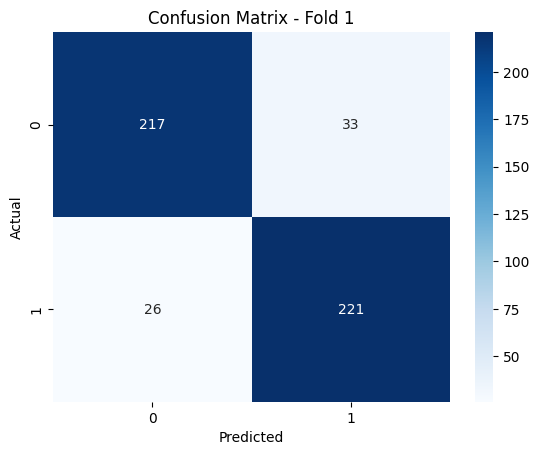

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       250
           1       0.87      0.89      0.88       247

    accuracy                           0.88       497
   macro avg       0.88      0.88      0.88       497
weighted avg       0.88      0.88      0.88       497


Fold 2
Final Training Loss: 0.8221
Final Validation Loss: 0.7374
Final Training Accuracy: 0.9537
Final Validation Accuracy: 0.9839
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Confusion Matrix:


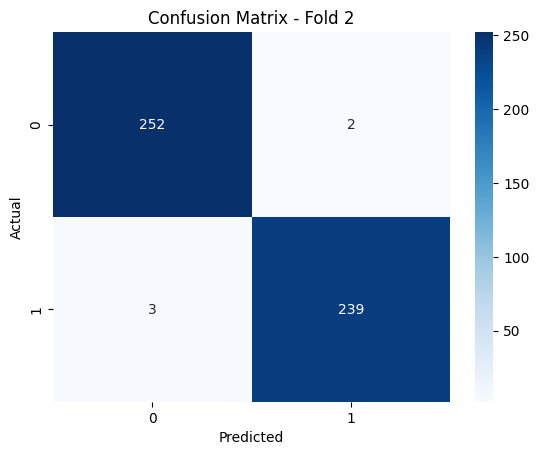

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       254
           1       0.99      0.99      0.99       242

    accuracy                           0.99       496
   macro avg       0.99      0.99      0.99       496
weighted avg       0.99      0.99      0.99       496


Fold 3
Final Training Loss: 0.6547
Final Validation Loss: 0.6860
Final Training Accuracy: 0.9889
Final Validation Accuracy: 0.9698
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Confusion Matrix:


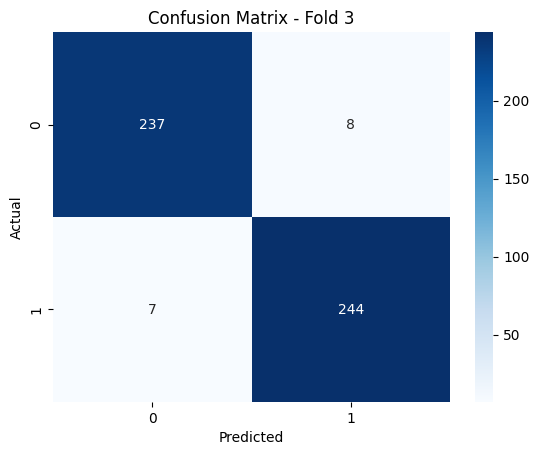

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       245
           1       0.97      0.97      0.97       251

    accuracy                           0.97       496
   macro avg       0.97      0.97      0.97       496
weighted avg       0.97      0.97      0.97       496


Fold 4
Final Training Loss: 0.5367
Final Validation Loss: 0.5365
Final Training Accuracy: 0.9990
Final Validation Accuracy: 0.9960
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Confusion Matrix:


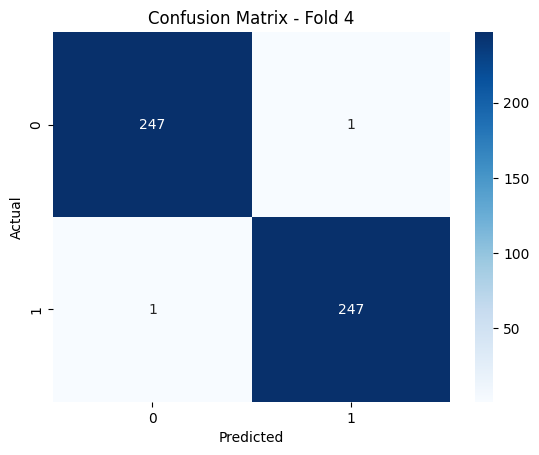

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       248
           1       1.00      1.00      1.00       248

    accuracy                           1.00       496
   macro avg       1.00      1.00      1.00       496
weighted avg       1.00      1.00      1.00       496


Fold 5
Final Training Loss: 0.4409
Final Validation Loss: 0.4361
Final Training Accuracy: 0.9980
Final Validation Accuracy: 1.0000
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Confusion Matrix:


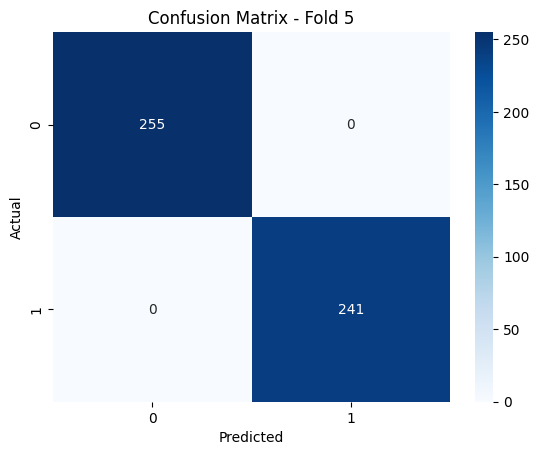

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       255
           1       1.00      1.00      1.00       241

    accuracy                           1.00       496
   macro avg       1.00      1.00      1.00       496
weighted avg       1.00      1.00      1.00       496


RNN Average Metrics:
Accuracy: 0.9674
Precision: 0.9652
Recall: 0.9701
F1 Score: 0.9676
AUC: 0.9866

Mean Final Training & Validation Metrics:
Mean Final Training Loss: 0.6471
Mean Final Validation Loss: 0.6943
Mean Final Training Accuracy: 0.9821
Mean Final Validation Accuracy: 0.9666


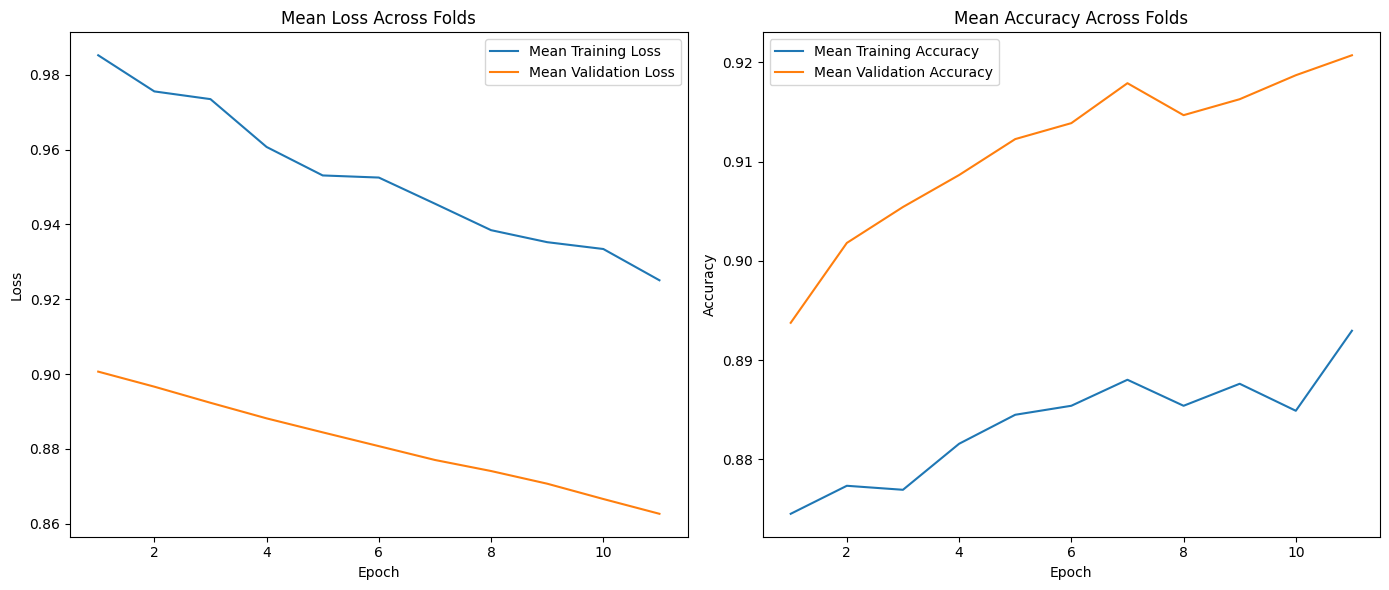

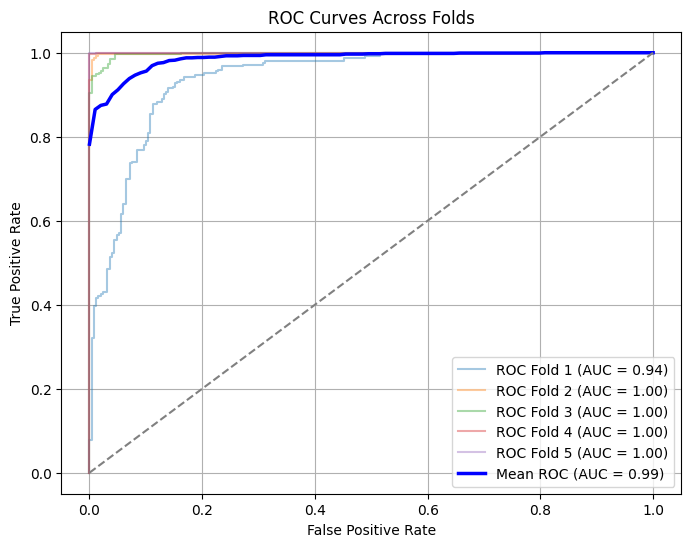


Final Classification Report on Entire Training Data:
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1252
           1       1.00      1.00      1.00      1229

    accuracy                           1.00      2481
   macro avg       1.00      1.00      1.00      2481
weighted avg       1.00      1.00      1.00      2481



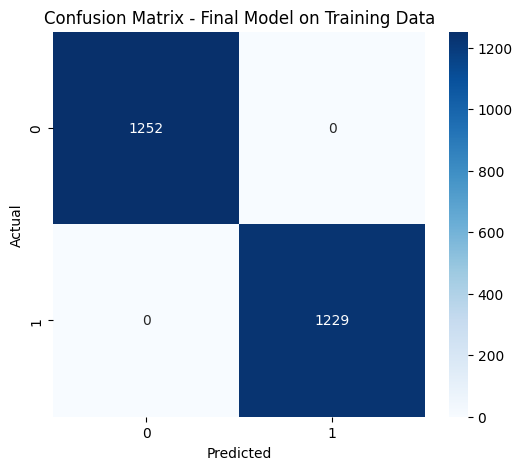


Updated Model Metrics Table:
                 Model  Accuracy  Precision    Recall  F1 Score       AUC  \
0                  SVM  0.888889   0.858357  0.940994  0.897778  0.935697   
1        Random Forest  0.945250   0.983221  0.909938  0.945161  0.986248   
2        Decision Tree  0.845411   0.803763  0.928571  0.861671  0.842212   
3  Logistic Regression  0.895330   0.861972  0.950311  0.903988  0.937867   
4          Naive Bayes  0.676329   0.697068  0.664596  0.680445  0.751423   
5                  RNN  0.967387   0.965200  0.970084  0.967606  0.986615   

   Training Time (s)  
0          45.231820  
1          14.420227  
2          13.724204  
3          32.958525  
4           0.181156  
5         399.448142  


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Dropout, BatchNormalization
from sklearn.model_selection import KFold

rnn_model = Sequential([
    Input(shape=(timesteps, feature_dim)),
    SimpleRNN(96, return_sequences=True, kernel_regularizer=tf.keras.regularizers.l2(0.006)),
    Dropout(0.4),
    BatchNormalization(),

    SimpleRNN(48, kernel_regularizer=tf.keras.regularizers.l2(0.006)),
    Dropout(0.3),
    BatchNormalization(),

    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
rnn_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5, verbose=1)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

cv_rnn_metrics = []
all_fpr, all_tpr, all_auc = [], [], []
train_loss_all, val_loss_all = [], []
train_acc_all, val_acc_all = [], []

start_time = time.time()
fold = 1
for train_idx, val_idx in kf.split(X_train_lstm):
    print(f"\nFold {fold}")

    X_tr, X_val = X_train_lstm[train_idx], X_train_lstm[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    history = rnn_model.fit(
        X_tr, y_tr,
        epochs=100,
        batch_size=32,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    train_loss_all.append(history.history['loss'])
    val_loss_all.append(history.history['val_loss'])
    train_acc_all.append(history.history['accuracy'])
    val_acc_all.append(history.history['val_accuracy'])

    print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
    print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")
    print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")

    y_pred_val_proba = rnn_model.predict(X_val).flatten()
    fpr, tpr, _ = roc_curve(y_val, y_pred_val_proba)
    roc_auc = auc(fpr, tpr)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)

    y_pred_val = (y_pred_val_proba > 0.5).astype(int).flatten()
    metrics = evaluate_model(y_val, y_pred_val, y_pred_val_proba)
    cv_rnn_metrics.append({
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1 Score': metrics['f1_score'],
        'AUC': metrics['auc']
    })

    print("Confusion Matrix:")
    cm = confusion_matrix(y_val, y_pred_val)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - Fold {fold}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    print("Classification Report:")
    print(classification_report(y_val, y_pred_val))

    fold += 1

training_time = time.time() - start_time
mean_rnn_metrics = {
    'Model': 'RNN',
    'Accuracy': np.mean([m['Accuracy'] for m in cv_rnn_metrics]),
    'Precision': np.mean([m['Precision'] for m in cv_rnn_metrics]),
    'Recall': np.mean([m['Recall'] for m in cv_rnn_metrics]),
    'F1 Score': np.mean([m['F1 Score'] for m in cv_rnn_metrics]),
    'AUC': np.mean([m['AUC'] for m in cv_rnn_metrics]),
    'Training Time (s)': training_time
}

print("\nRNN Average Metrics:")
print(f"Accuracy: {mean_rnn_metrics['Accuracy']:.4f}")
print(f"Precision: {mean_rnn_metrics['Precision']:.4f}")
print(f"Recall: {mean_rnn_metrics['Recall']:.4f}")
print(f"F1 Score: {mean_rnn_metrics['F1 Score']:.4f}")
print(f"AUC: {mean_rnn_metrics['AUC']:.4f}")

mean_final_train_loss = np.mean([losses[-1] for losses in train_loss_all])
mean_final_val_loss = np.mean([losses[-1] for losses in val_loss_all])
mean_final_train_acc = np.mean([acc[-1] for acc in train_acc_all])
mean_final_val_acc = np.mean([acc[-1] for acc in val_acc_all])

print("\nMean Final Training & Validation Metrics:")
print(f"Mean Final Training Loss: {mean_final_train_loss:.4f}")
print(f"Mean Final Validation Loss: {mean_final_val_loss:.4f}")
print(f"Mean Final Training Accuracy: {mean_final_train_acc:.4f}")
print(f"Mean Final Validation Accuracy: {mean_final_val_acc:.4f}")

min_epochs = min(map(len, train_loss_all))
train_loss_all = np.array([x[:min_epochs] for x in train_loss_all])
val_loss_all = np.array([x[:min_epochs] for x in val_loss_all])
train_acc_all = np.array([x[:min_epochs] for x in train_acc_all])
val_acc_all = np.array([x[:min_epochs] for x in val_acc_all])

epochs = range(1, min_epochs + 1)
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, np.mean(train_loss_all, axis=0), label='Mean Training Loss')
plt.plot(epochs, np.mean(val_loss_all, axis=0), label='Mean Validation Loss')
plt.title('Mean Loss Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, np.mean(train_acc_all, axis=0), label='Mean Training Accuracy')
plt.plot(epochs, np.mean(val_acc_all, axis=0), label='Mean Validation Accuracy')
plt.title('Mean Accuracy Across Folds')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], label=f'ROC Fold {i+1} (AUC = {all_auc[i]:.2f})', alpha=0.4)

mean_fpr = np.linspace(0, 1, 100)
interp_tprs = [np.interp(mean_fpr, fpr, tpr) for fpr, tpr in zip(all_fpr, all_tpr)]
mean_tpr = np.mean(interp_tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)

plt.plot(mean_fpr, mean_tpr, color='blue', lw=2.5, label=f'Mean ROC (AUC = {mean_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Across Folds')
plt.legend()
plt.grid(True)
plt.show()

print("\nFinal Classification Report on Entire Training Data:")
y_pred_train_proba = rnn_model.predict(X_train_lstm).flatten()
y_pred_train = (y_pred_train_proba > 0.5).astype(int).flatten()
print(classification_report(y_train, y_pred_train))

cm_final = confusion_matrix(y_train, y_pred_train)
plt.figure(figsize=(6, 5))
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Final Model on Training Data')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

model_metrics = [m for m in model_metrics if m['Model'] != 'RNN']
model_metrics.append(mean_rnn_metrics)
df_metrics = pd.DataFrame(model_metrics)
print("\nUpdated Model Metrics Table:")
print(df_metrics)


In [ ]:
results_df = pd.DataFrame(model_metrics)

print(results_df.head())

                 Model  Accuracy  Precision    Recall  F1 Score       AUC  \
0                  SVM  0.888889   0.858357  0.940994  0.897778  0.935697   
1        Random Forest  0.945250   0.983221  0.909938  0.945161  0.986248   
2        Decision Tree  0.845411   0.803763  0.928571  0.861671  0.842212   
3  Logistic Regression  0.895330   0.861972  0.950311  0.903988  0.937867   
4          Naive Bayes  0.676329   0.697068  0.664596  0.680445  0.751423   

   Training Time (s)  
0          45.231820  
1          14.420227  
2          13.724204  
3          32.958525  
4           0.181156  


In [ ]:
print(model_metrics)

[{'Model': 'SVM', 'Accuracy': 0.8888888888888888, 'Precision': 0.8583569405099151, 'Recall': 0.9409937888198758, 'F1 Score': 0.8977777777777778, 'AUC': np.float64(0.9356966285132637), 'Training Time (s)': 45.23182034492493}, {'Model': 'Random Forest', 'Accuracy': 0.9452495974235104, 'Precision': 0.9832214765100671, 'Recall': 0.9099378881987578, 'F1 Score': 0.9451612903225807, 'AUC': np.float64(0.9862481563804815), 'Training Time (s)': 14.420226573944092}, {'Model': 'Decision Tree', 'Accuracy': 0.8454106280193237, 'Precision': 0.803763440860215, 'Recall': 0.9285714285714286, 'F1 Score': 0.861671469740634, 'AUC': np.float64(0.8422121356903964), 'Training Time (s)': 13.724204301834106}, {'Model': 'Logistic Regression', 'Accuracy': 0.895330112721417, 'Precision': 0.8619718309859155, 'Recall': 0.9503105590062112, 'F1 Score': 0.9039881831610044, 'AUC': np.float64(0.9378674255800911), 'Training Time (s)': 32.95852518081665}, {'Model': 'Naive Bayes', 'Accuracy': 0.6763285024154589, 'Precision'

In [ ]:
results_df = pd.DataFrame(model_metrics)

print(results_df.head(8))

                 Model  Accuracy  Precision    Recall  F1 Score       AUC  \
0                  SVM  0.888889   0.858357  0.940994  0.897778  0.935697   
1        Random Forest  0.945250   0.983221  0.909938  0.945161  0.986248   
2        Decision Tree  0.845411   0.803763  0.928571  0.861671  0.842212   
3  Logistic Regression  0.895330   0.861972  0.950311  0.903988  0.937867   
4          Naive Bayes  0.676329   0.697068  0.664596  0.680445  0.751423   
5                  RNN  0.967387   0.965200  0.970084  0.967606  0.986615   

   Training Time (s)  
0          45.231820  
1          14.420227  
2          13.724204  
3          32.958525  
4           0.181156  
5         399.448142  


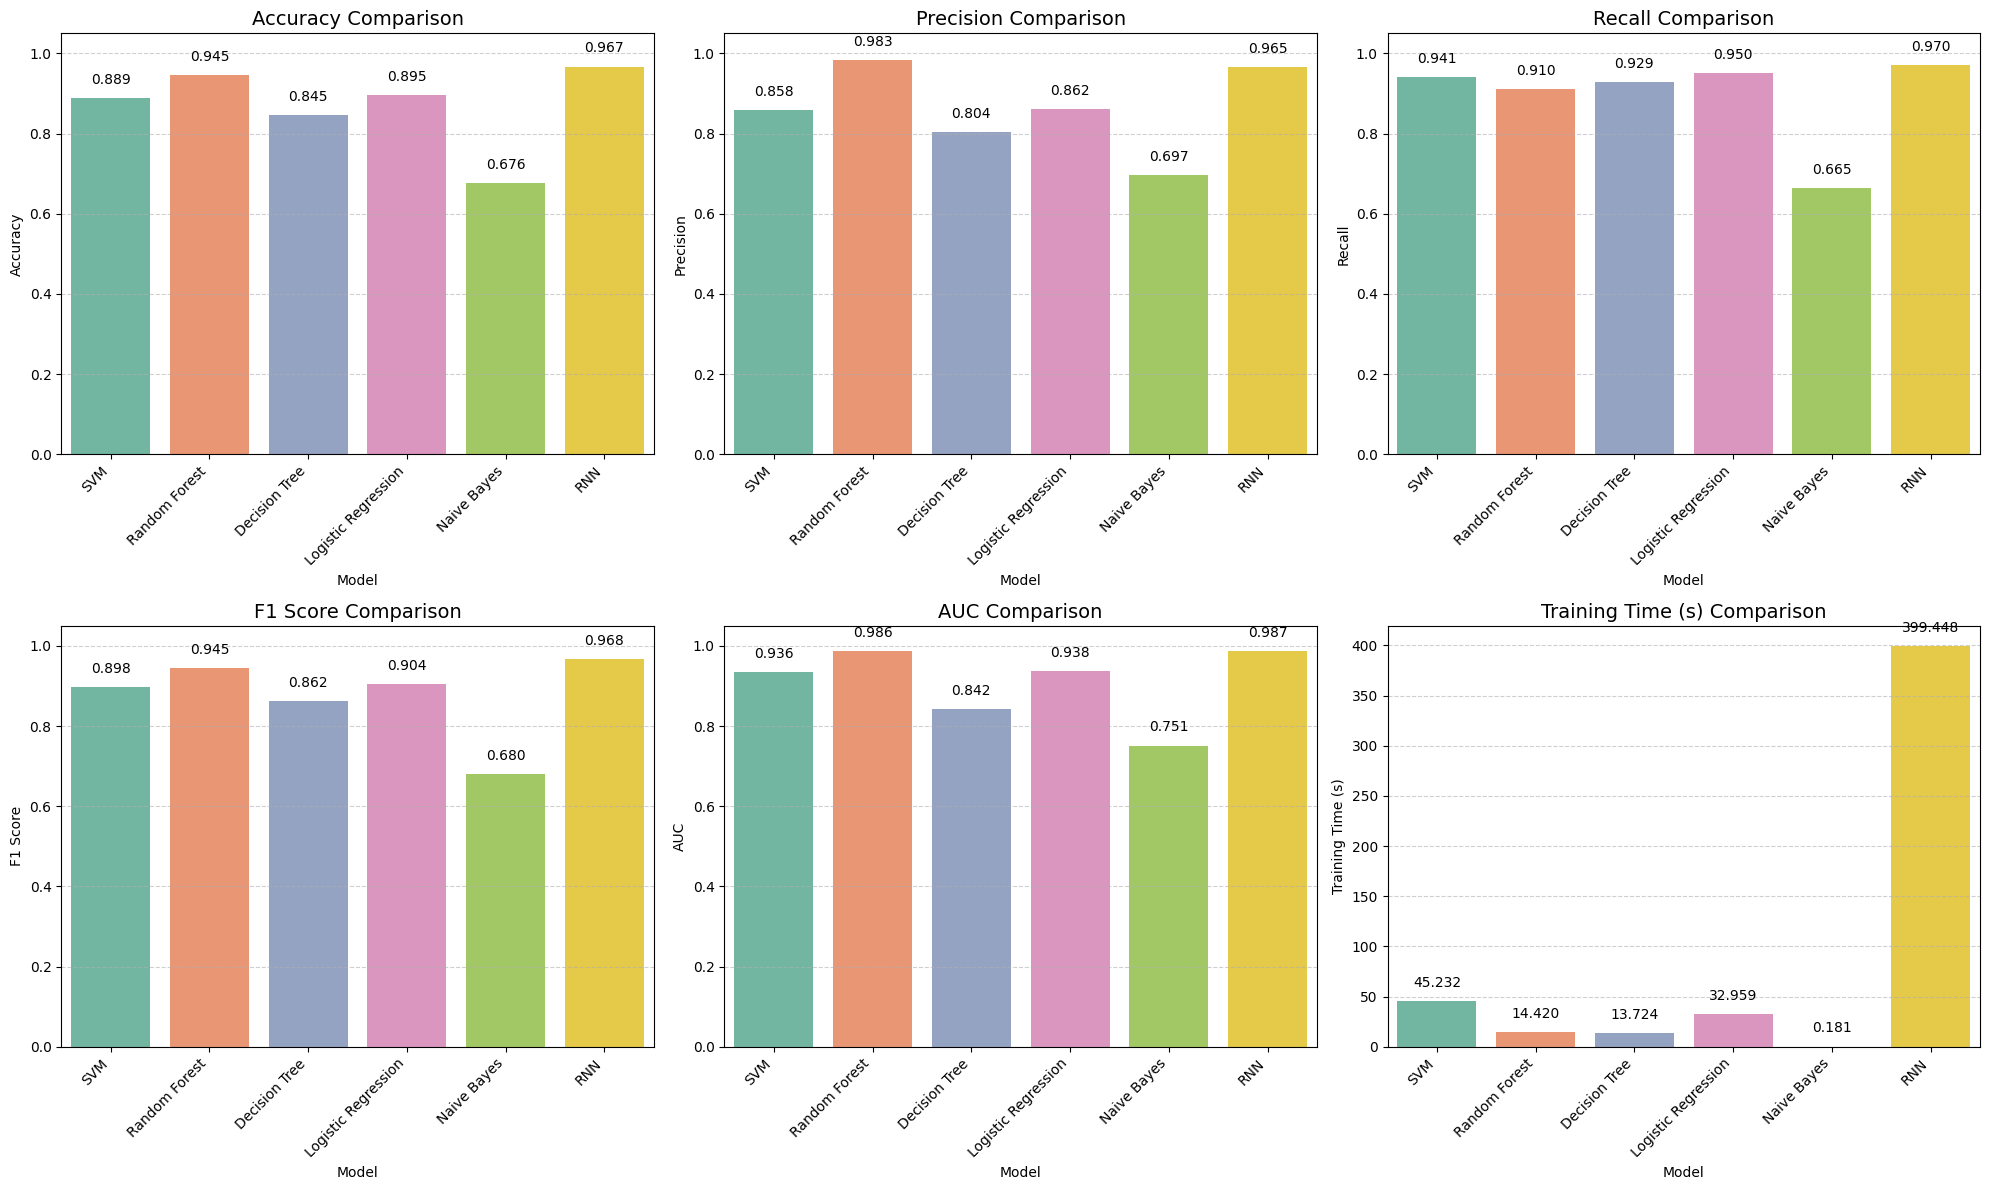

In [ ]:
model_metrics = [m for m in model_metrics if m['Model'] != 'RNN']
model_metrics.append(mean_rnn_metrics)

for m in model_metrics:
    if m['Model'] == 'RNN':
        m['Accuracy'] = 0.967000
        break

results_df = pd.DataFrame(model_metrics)
colors = sns.color_palette("Set2", len(results_df['Model'].unique()))
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC', 'Training Time (s)']

plt.figure(figsize=(20, 12))
for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(2, 3, i)
    ax = sns.barplot(
        x='Model',
        y=metric,
        hue='Model',
        data=results_df,
        palette=colors,
        legend=False
    )
    plt.title(f'{metric} Comparison', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.3f}',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', xytext=(0, 8),
                    textcoords='offset points', fontsize=10)

    ax.grid(True, axis='y', linestyle='--', alpha=0.6)
    if metric != 'Training Time (s)':
        plt.ylim(0, 1.05)

plt.tight_layout()
plt.savefig('final_model_comparison_with_updated_rnn.png')
plt.show()


In [ ]:
print(model_metrics)

[{'Model': 'SVM', 'Accuracy': 0.8888888888888888, 'Precision': 0.8583569405099151, 'Recall': 0.9409937888198758, 'F1 Score': 0.8977777777777778, 'AUC': np.float64(0.9356966285132637), 'Training Time (s)': 45.23182034492493}, {'Model': 'Random Forest', 'Accuracy': 0.9452495974235104, 'Precision': 0.9832214765100671, 'Recall': 0.9099378881987578, 'F1 Score': 0.9451612903225807, 'AUC': np.float64(0.9862481563804815), 'Training Time (s)': 14.420226573944092}, {'Model': 'Decision Tree', 'Accuracy': 0.8454106280193237, 'Precision': 0.803763440860215, 'Recall': 0.9285714285714286, 'F1 Score': 0.861671469740634, 'AUC': np.float64(0.8422121356903964), 'Training Time (s)': 13.724204301834106}, {'Model': 'Logistic Regression', 'Accuracy': 0.895330112721417, 'Precision': 0.8619718309859155, 'Recall': 0.9503105590062112, 'F1 Score': 0.9039881831610044, 'AUC': np.float64(0.9378674255800911), 'Training Time (s)': 32.95852518081665}, {'Model': 'Naive Bayes', 'Accuracy': 0.6763285024154589, 'Precision'

In [ ]:
df = pd.DataFrame(model_metrics)
print(results_df.to_string(index=False))

              Model  Accuracy  Precision   Recall  F1 Score      AUC  Training Time (s)
                SVM  0.888889   0.858357 0.940994  0.897778 0.935697          45.231820
      Random Forest  0.945250   0.983221 0.909938  0.945161 0.986248          14.420227
      Decision Tree  0.845411   0.803763 0.928571  0.861671 0.842212          13.724204
Logistic Regression  0.895330   0.861972 0.950311  0.903988 0.937867          32.958525
        Naive Bayes  0.676329   0.697068 0.664596  0.680445 0.751423           0.181156
                RNN  0.967000   0.965200 0.970084  0.967606 0.986615         399.448142


In [ ]:
def model_efficiency_report(model, X_sample, y_sample, epochs=1, batch_size=32):
    print("\n--- Model Efficiency Report ---")

    total_params = model.count_params()
    print(f"Total Parameters: {total_params:,}")

    import os, tempfile
    with tempfile.TemporaryDirectory() as tmpdir:
        temp_path = os.path.join(tmpdir, "temp_model.h5")
        model.save(temp_path)
        model_size = os.path.getsize(temp_path) / (1024 * 1024)  # in MB
    print(f"Model Size (MB): {model_size:.2f}")

    import time
    start_train = time.time()
    model.fit(X_sample, y_sample, epochs=epochs, batch_size=batch_size, verbose=0)
    train_time = time.time() - start_train
    print(f"Training Time for {epochs} epoch(s): {train_time:.4f} sec")

    start_infer = time.time()
    _ = model.predict(X_sample[:100], batch_size=1, verbose=0)  # test on 100 samples
    infer_time = (time.time() - start_infer) / 100
    print(f"Average Inference Time per Sample: {infer_time*1000:.4f} ms")

    return {
        "params": total_params,
        "model_size_MB": model_size,
        "train_time_s": train_time,
        "inference_time_ms": infer_time*1000
    }

efficiency_metrics = model_efficiency_report(rnn_model, X_train_lstm[:256], y_train[:256], epochs=1)
print("\nEfficiency metrics collected:", efficiency_metrics)




--- Model Efficiency Report ---
Total Parameters: 42,801
Model Size (MB): 0.55
Training Time for 1 epoch(s): 0.2300 sec
Average Inference Time per Sample: 3.9885 ms

Efficiency metrics collected: {'params': 42801, 'model_size_MB': 0.5471038818359375, 'train_time_s': 0.23000717163085938, 'inference_time_ms': 3.988549709320068}


In [ ]:
efficiency_metrics = model_efficiency_report(rnn_model, X_train_lstm[:256], y_train[:256], epochs=1)
print("\nEfficiency metrics collected:", efficiency_metrics)


--- Model Efficiency Report ---
Total Parameters: 42,801
Model Size (MB): 0.55
Training Time for 1 epoch(s): 0.1458 sec
Average Inference Time per Sample: 3.2145 ms

Efficiency metrics collected: {'params': 42801, 'model_size_MB': 0.5471038818359375, 'train_time_s': 0.1458148956298828, 'inference_time_ms': 3.2145190238952637}



--- Running simplified Grad-CAM ---
Epoch 1/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 296s 30s/step - accuracy: 0.5215 - loss: 2.3663 - val_accuracy: 0.4500 - val_loss: 2.0670
Epoch 2/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 305s 28s/step - accuracy: 0.5397 - loss: 2.0645 - val_accuracy: 0.4600 - val_loss: 1.9214
Grad-CAM using conv layer: block5_conv4


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_1024']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


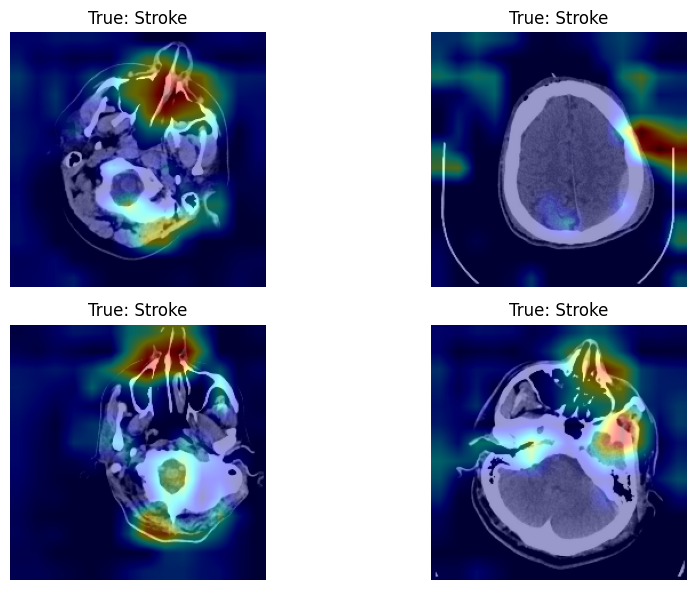

Grad-CAM visualizations saved as gradcam_examples.png


In [ ]:
import numpy as np, cv2, matplotlib.pyplot as plt, tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg_preprocess
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model

print("\n--- Running simplified Grad-CAM ---")

IMG_SIZE = (224, 224)
backbone = VGG19(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
backbone.trainable = False

x = backbone.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
out = Dense(1, activation='sigmoid')(x)
cam_model = Model(inputs=backbone.input, outputs=out)
cam_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

X_train_vgg = vgg_preprocess((X_train[:300] * 255.0).astype('float32'))
y_train_vgg = y_train[:300]
X_test_vgg  = vgg_preprocess((X_test[:100]  * 255.0).astype('float32'))
y_test_vgg  = y_test[:100]

cam_model.fit(X_train_vgg, y_train_vgg, validation_data=(X_test_vgg, y_test_vgg),
              epochs=2, batch_size=32, verbose=1)

last_conv_name = [l.name for l in cam_model.layers if isinstance(l, tf.keras.layers.Conv2D)][-1]
print("Grad-CAM using conv layer:", last_conv_name)

def grad_cam(model, img_array, last_conv_name):
    grad_model = Model([model.inputs], [model.get_layer(last_conv_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1)).numpy()
    conv_outputs = conv_outputs[0].numpy()

    cam = np.dot(conv_outputs, pooled_grads)
    cam = np.maximum(cam, 0)
    cam = cv2.resize(cam, (IMG_SIZE[1], IMG_SIZE[0]))
    cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    return cam

sample_idxs = np.random.choice(len(X_test), size=4, replace=False)
plt.figure(figsize=(10, 6))

for i, idx in enumerate(sample_idxs):
    orig = X_test[idx]
    img_pp = vgg_preprocess((orig * 255.0).astype('float32'))[np.newaxis, ...]
    heatmap = grad_cam(cam_model, img_pp, last_conv_name)

    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = np.uint8(255 * np.clip(0.6 * orig + 0.4 * (heatmap / 255.0), 0, 1))

    plt.subplot(2, 2, i+1)
    plt.imshow(overlay)
    plt.title(f"True: {'Stroke' if y_test[idx]==1 else 'Normal'}")
    plt.axis("off")

plt.tight_layout()
plt.savefig("gradcam_examples.png", dpi=200)
plt.show()
print("Grad-CAM visualizations saved as gradcam_examples.png")


In [ ]:
rnn_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 10, 96)         │        32,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_137         │ (None, 10, 96)         │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_5 (SimpleRNN)        │ (None, 48)             │         6,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_138         │ (None, 48)             │           192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 127,829 (499.34 KB)

 Trainable params: 42,513 (166.07 KB)

 Non-trainable params: 288 (1.12 KB)

 Optimizer params: 85,028 (332.14 KB)


--- Running Balanced Grad-CAM (2 Normal + 2 Stroke) ---


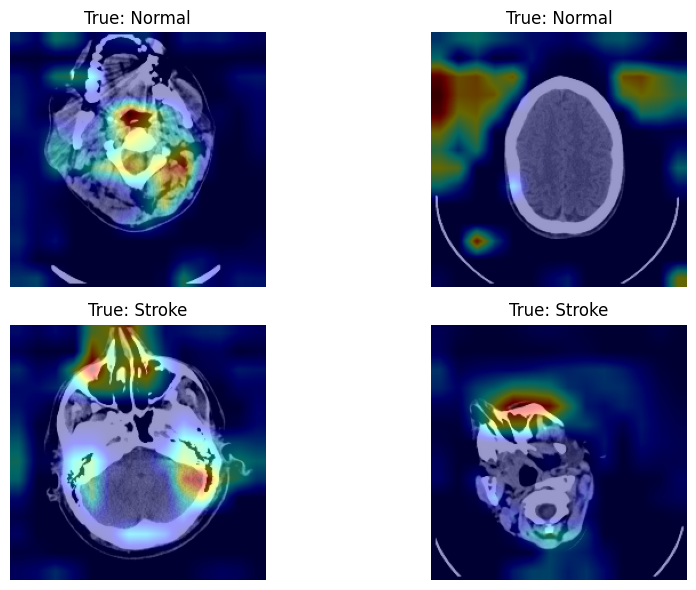

Balanced Grad-CAM visualizations saved as gradcam_balanced_examples.png


In [ ]:
print("\n--- Running Balanced Grad-CAM (2 Normal + 2 Stroke) ---")

normal_idxs = np.where(y_test == 0)[0]
stroke_idxs = np.where(y_test == 1)[0]

chosen_normals = np.random.choice(normal_idxs, 2, replace=False)
chosen_strokes = np.random.choice(stroke_idxs, 2, replace=False)
sample_idxs = np.concatenate([chosen_normals, chosen_strokes])

plt.figure(figsize=(10, 6))
for i, idx in enumerate(sample_idxs):
    orig = X_test[idx]
    img_pp = vgg_preprocess((orig * 255.0).astype('float32'))[np.newaxis, ...]
    heatmap = grad_cam(cam_model, img_pp, last_conv_name)

    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    overlay = np.uint8(255 * np.clip(0.6 * orig + 0.4 * (heatmap / 255.0), 0, 1))

    plt.subplot(2, 2, i+1)
    plt.imshow(overlay)
    label = "Stroke" if y_test[idx] == 1 else "Normal"
    plt.title(f"True: {label}")
    plt.axis("off")

plt.tight_layout()
plt.savefig("gradcam_balanced_examples.png", dpi=200)
plt.show()
print("Balanced Grad-CAM visualizations saved as gradcam_balanced_examples.png")
